<h1><center><font size="6">IEEE FRAUD DETECTION</font></center></h1>




<img src="https://gdprinformer.com/wp-content/uploads/2017/09/fraud-laptop.jpg" width="800"></img>



<br>

# <a id='0'>Content</a>

- <a href='#1'>Importing Libraries and Modules</a>  
- <a href='#2'>Distribution of features across Train and Test</a>
 - <a href='#21'>Card Features</a>   
  - <a href='#22'>Addr,Dist and EmailDomain</a>  
  - <a href='#23'>C Features</a> 
  - <a href='#24'>D Features</a> 
  - <a href='#25'>M features</a> 
  - <a href='#26'>V Features</a>   
  - <a href='#27'>ID features</a> 
- <a href='#3'>Dropping Columns</a>   
- <a href='#4'>Reducing Memory Size</a>    
- <a href='#5'>Feature Engineering</a>     
- <a href='#6'>Model Development</a>
- <a href='#7'>Feature Importance</a>


**Please upvote if you like the kernel . Happy Kaggling and all the best for the competition**

# <a id='1'>Importing Libraries and Modules</a> 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from hyperopt import tpe,hp,Trials
from hyperopt.fmin import fmin
import gc
import os
print(os.listdir("../input"))
seed=5
# Any results you write to the current directory are saved as output.

['train_identity.csv', 'train_transaction.csv', 'test_transaction.csv', 'test_identity.csv', 'sample_submission.csv']


In [2]:
train_identity=pd.read_csv('../input/train_identity.csv')
test_identity=pd.read_csv('../input/test_identity.csv')
train_transaction=pd.read_csv('../input/train_transaction.csv')
test_transaction=pd.read_csv('../input/test_transaction.csv')

In [3]:
train=pd.merge(train_transaction,train_identity,how='left',on='TransactionID')
test=pd.merge(test_transaction,test_identity,how='left',on='TransactionID')

In [4]:
del train_identity,test_identity,train_transaction,test_transaction

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


In [6]:
# most_null_values=[col for col in train.columns if (train[col].isna().sum()/train.shape[0])>0.9]
# len(most_null_values)

In [7]:
# dominant_unique_values=[col for col in train.columns if (train[col].value_counts().values[0]/train.shape[0])>0.9]
# len(dominant_unique_values)

In [8]:
# dominant_unique_values.remove('isFraud')

In [9]:
# cols_to_drop=list(set(most_null_values+dominant_unique_values+['TransactionID','TransactionDT']))
# train=train.drop(cols_to_drop,axis=1)
# test=test.drop(cols_to_drop,axis=1)

# <a id='2'>Distribution of features across Train and Test</a> 

In [10]:
train.columns[:50]

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4'],
      dtype='object')

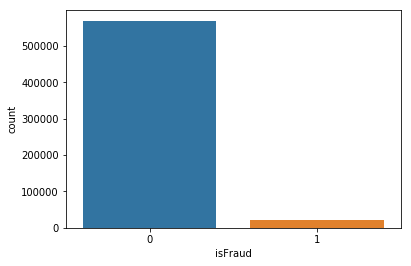

In [11]:
sns.countplot(train['isFraud'])

Text(0.5, 1.0, 'Test and Train TransationAmt Distribution')

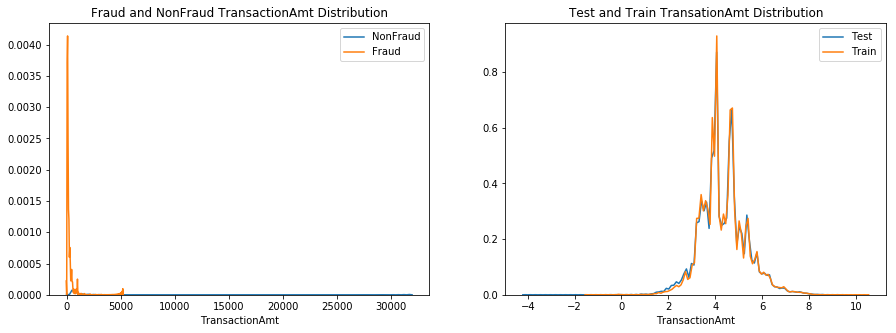

In [12]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
sns.distplot(train[train['isFraud']==0]['TransactionAmt'],ax=ax[0],hist=False,label='NonFraud')
sns.distplot(train[train['isFraud']==1]['TransactionAmt'],ax=ax[0],hist=False,label='Fraud')
ax[0].set_title('Fraud and NonFraud TransactionAmt Distribution')

sns.distplot(np.log(test['TransactionAmt']),ax=ax[1],hist=False,label='Test')
sns.distplot(np.log(train['TransactionAmt']),ax=ax[1],hist=False,label='Train')
ax[1].set_title('Test and Train TransationAmt Distribution')

Remember to take log of Transaction Amount. 

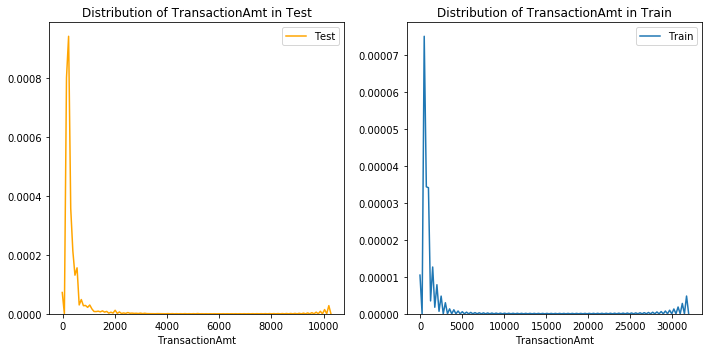

In [13]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
sns.distplot(test['TransactionAmt'],hist=False,label='Test',ax=ax[0],color='orange')
ax[0].set_title('Distribution of TransactionAmt in Test')
sns.distplot(train['TransactionAmt'],hist=False,label='Train',ax=ax[1])
ax[1].set_title('Distribution of TransactionAmt in Train')
plt.tight_layout()

Remove the Transaction amout outliers or take log.

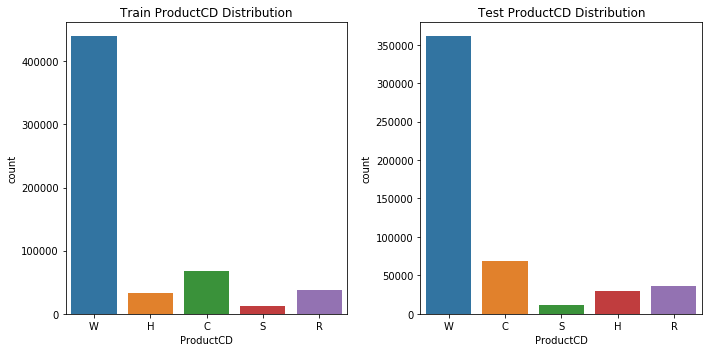

In [14]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
sns.countplot(train['ProductCD'],ax=ax[0])
ax[0].set_title('Train ProductCD Distribution')

sns.countplot(test['ProductCD'],ax=ax[1],label='Test')
ax[1].set_title('Test ProductCD Distribution')

plt.tight_layout()


## <a id='21'>Distribution of  Card features across Train and Test</a> 

In [15]:
card_cols=['card1','card2','card3','card4','card5','card6']
for c in card_cols:
    print(f'Number of unique variables in {c}: ',train[c].nunique())

Number of unique variables in card1:  13553
Number of unique variables in card2:  500
Number of unique variables in card3:  114
Number of unique variables in card4:  4
Number of unique variables in card5:  119
Number of unique variables in card6:  4


Text(0.5, 1.0, 'Test and Train Card1 Distribution')

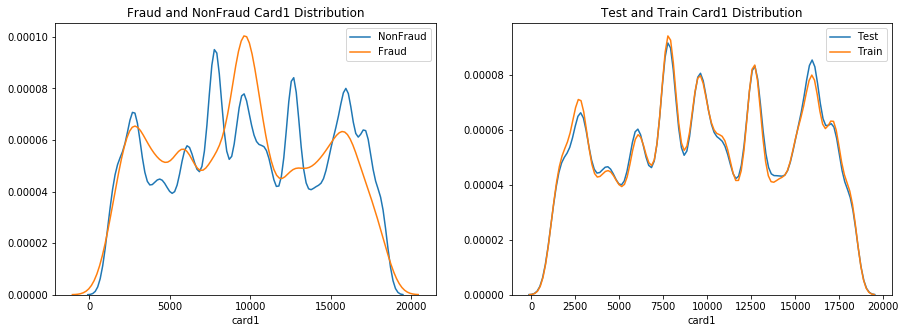

In [16]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
sns.distplot(train[train['isFraud']==0]['card1'],ax=ax[0],hist=False,label='NonFraud')
sns.distplot(train[train['isFraud']==1]['card1'],ax=ax[0],hist=False,label='Fraud')
ax[0].set_title('Fraud and NonFraud Card1 Distribution')

sns.distplot(test['card1'],ax=ax[1],hist=False,label='Test')
sns.distplot(train['card1'],ax=ax[1],hist=False,label='Train')
ax[1].set_title('Test and Train Card1 Distribution')

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0.5, 1.0, 'Test and Train Card1 Distribution')

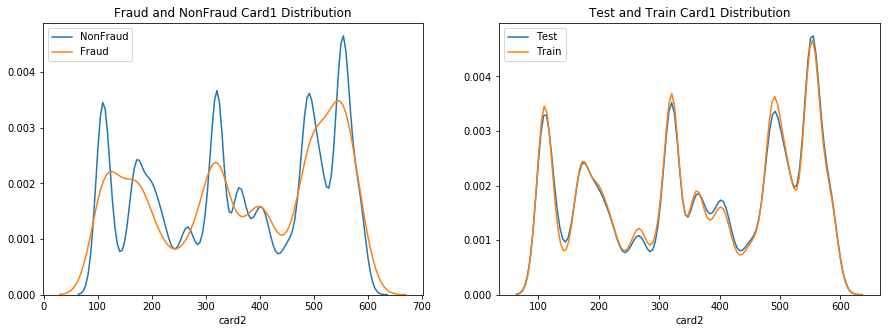

In [17]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
sns.distplot(train[train['isFraud']==0]['card2'],ax=ax[0],hist=False,label='NonFraud')
sns.distplot(train[train['isFraud']==1]['card2'],ax=ax[0],hist=False,label='Fraud')
ax[0].set_title('Fraud and NonFraud Card1 Distribution')

sns.distplot(test['card2'],ax=ax[1],hist=False,label='Test')
sns.distplot(train['card2'],ax=ax[1],hist=False,label='Train')
ax[1].set_title('Test and Train Card1 Distribution')

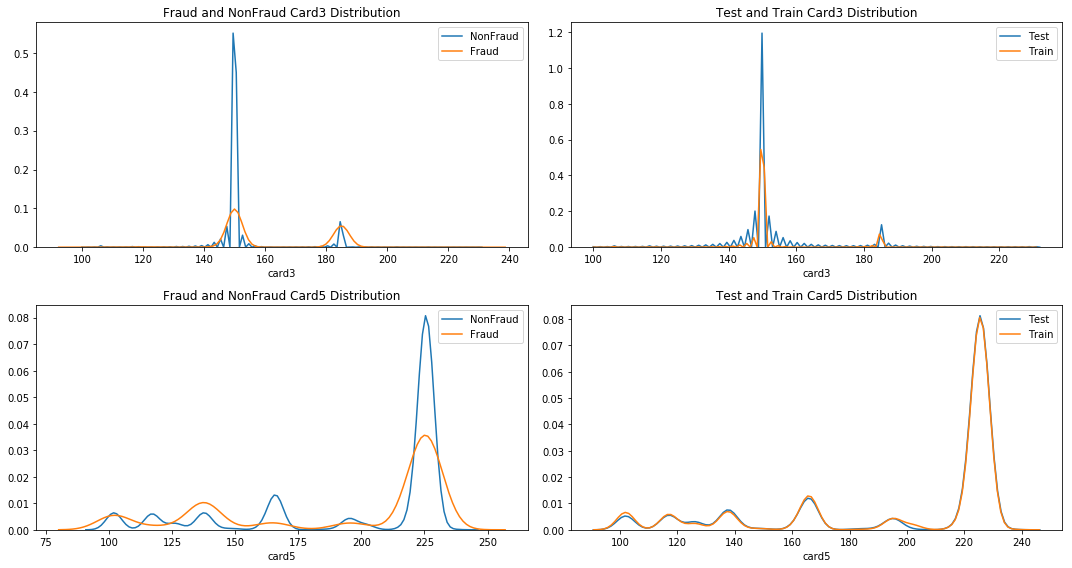

In [18]:
fig,ax=plt.subplots(2,2,figsize=(15,8))
sns.distplot(train[train['isFraud']==0]['card3'],ax=ax[0,0],hist=False,label='NonFraud')
sns.distplot(train[train['isFraud']==1]['card3'],ax=ax[0,0],hist=False,label='Fraud')
ax[0,0].set_title('Fraud and NonFraud Card3 Distribution')

sns.distplot(test['card3'],ax=ax[0,1],hist=False,label='Test')
sns.distplot(train['card3'],ax=ax[0,1],hist=False,label='Train')
ax[0,1].set_title('Test and Train Card3 Distribution')

sns.distplot(train[train['isFraud']==0]['card5'],ax=ax[1,0],hist=False,label='NonFraud')
sns.distplot(train[train['isFraud']==1]['card5'],ax=ax[1,0],hist=False,label='Fraud')
ax[1,0].set_title('Fraud and NonFraud Card5 Distribution')

sns.distplot(test['card5'],ax=ax[1,1],hist=False,label='Test')
sns.distplot(train['card5'],ax=ax[1,1],hist=False,label='Train')
ax[1,1].set_title('Test and Train Card5 Distribution')

plt.tight_layout()

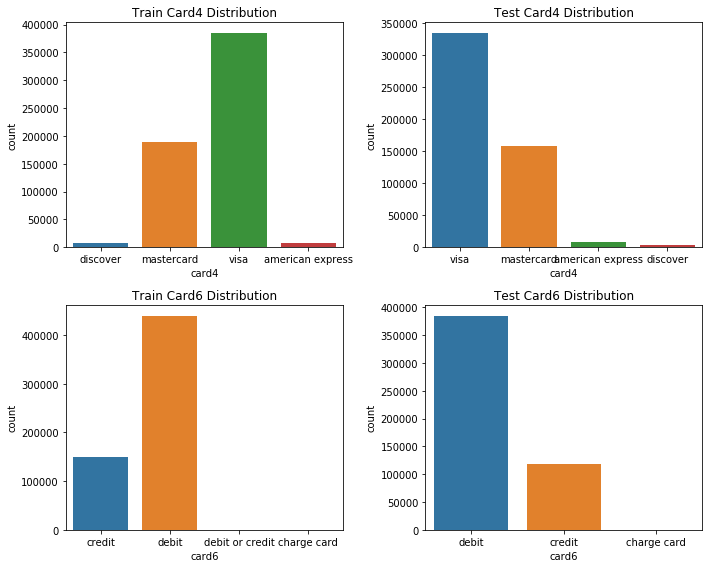

In [19]:
fig,ax=plt.subplots(2,2,figsize=(10,8))
sns.countplot(train['card4'],ax=ax[0,0])
ax[0,0].set_title('Train Card4 Distribution')

sns.countplot(test['card4'],ax=ax[0,1])
ax[0,1].set_title('Test Card4 Distribution')

sns.countplot(train['card6'],ax=ax[1,0])
ax[1,0].set_title('Train Card6 Distribution')

sns.countplot(test['card6'],ax=ax[1,1])
ax[1,1].set_title('Test Card6 Distribution')

plt.tight_layout()

## <a id='22'>Distribution of Addr,Dist and Emaildomain across Train and Test</a> 

In [20]:
train.columns[:50]

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4'],
      dtype='object')

In [21]:
addr=['addr1','addr2','dist1','dist2','P_emaildomain','R_emaildomain']
for c in addr:
    print(f'Number of unique variables in {c}: ',train[c].nunique())

Number of unique variables in addr1:  332
Number of unique variables in addr2:  74
Number of unique variables in dist1:  2651
Number of unique variables in dist2:  1751
Number of unique variables in P_emaildomain:  59
Number of unique variables in R_emaildomain:  60


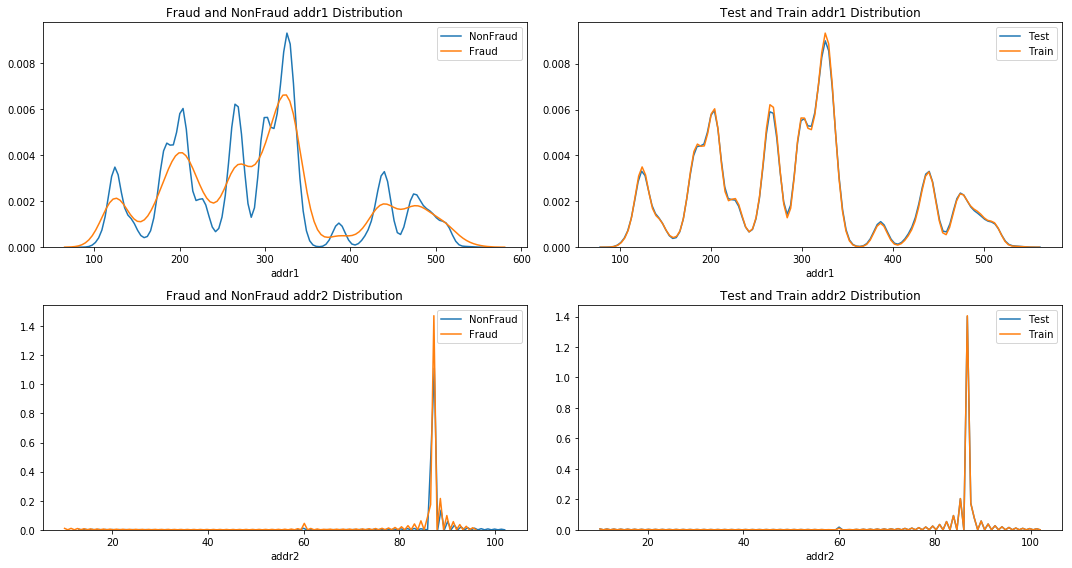

In [22]:
fig,ax=plt.subplots(2,2,figsize=(15,8))
sns.distplot(train[train['isFraud']==0]['addr1'],ax=ax[0,0],hist=False,label='NonFraud')
sns.distplot(train[train['isFraud']==1]['addr1'],ax=ax[0,0],hist=False,label='Fraud')
ax[0,0].set_title('Fraud and NonFraud addr1 Distribution')

sns.distplot(test['addr1'],ax=ax[0,1],hist=False,label='Test')
sns.distplot(train['addr1'],ax=ax[0,1],hist=False,label='Train')
ax[0,1].set_title('Test and Train addr1 Distribution')

sns.distplot(train[train['isFraud']==0]['addr2'],ax=ax[1,0],hist=False,label='NonFraud')
sns.distplot(train[train['isFraud']==1]['addr2'],ax=ax[1,0],hist=False,label='Fraud')
ax[1,0].set_title('Fraud and NonFraud addr2 Distribution')

sns.distplot(test['addr2'],ax=ax[1,1],hist=False,label='Test')
sns.distplot(train['addr2'],ax=ax[1,1],hist=False,label='Train')
ax[1,1].set_title('Test and Train addr2 Distribution')

plt.tight_layout()

addr2 of test perfectly overlaps the addr2 of train and so it is not seen.

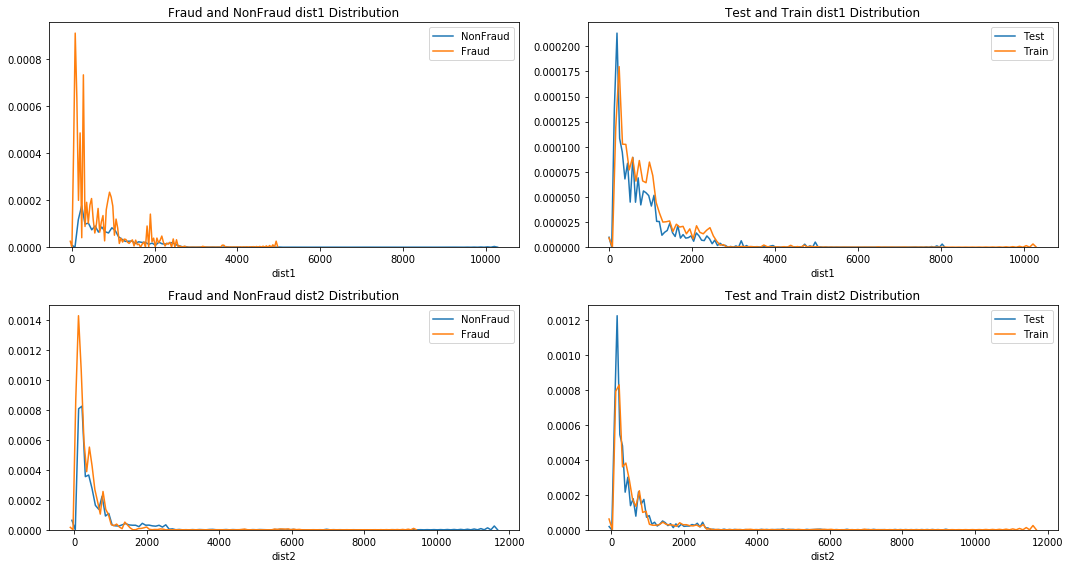

In [23]:
fig,ax=plt.subplots(2,2,figsize=(15,8))
sns.distplot(train[train['isFraud']==0]['dist1'],ax=ax[0,0],hist=False,label='NonFraud')
sns.distplot(train[train['isFraud']==1]['dist1'],ax=ax[0,0],hist=False,label='Fraud')
ax[0,0].set_title('Fraud and NonFraud dist1 Distribution')

sns.distplot(test['dist1'],ax=ax[0,1],hist=False,label='Test')
sns.distplot(train['dist1'],ax=ax[0,1],hist=False,label='Train')
ax[0,1].set_title('Test and Train dist1 Distribution')

sns.distplot(train[train['isFraud']==0]['dist2'],ax=ax[1,0],hist=False,label='NonFraud')
sns.distplot(train[train['isFraud']==1]['dist2'],ax=ax[1,0],hist=False,label='Fraud')
ax[1,0].set_title('Fraud and NonFraud dist2 Distribution')

sns.distplot(test['dist2'],ax=ax[1,1],hist=False,label='Test')
sns.distplot(train['dist2'],ax=ax[1,1],hist=False,label='Train')
ax[1,1].set_title('Test and Train dist2 Distribution')

plt.tight_layout()

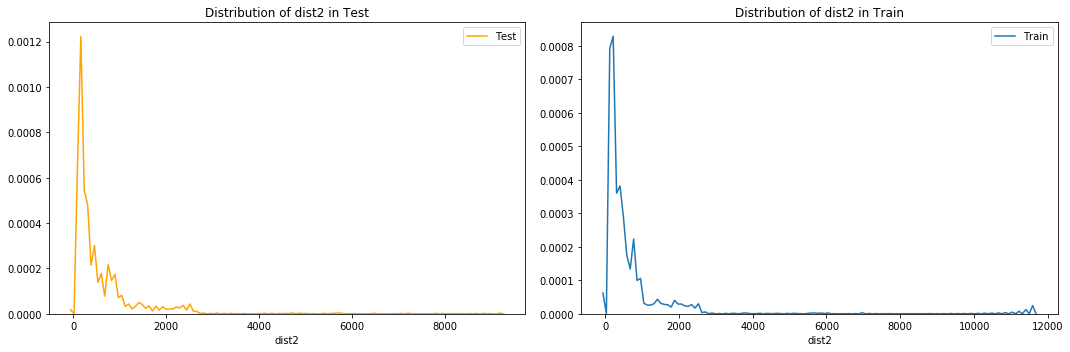

In [24]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
sns.distplot(test['dist2'],hist=False,label='Test',ax=ax[0],color='orange')
ax[0].set_title('Distribution of dist2 in Test')
sns.distplot(train['dist2'],hist=False,label='Train',ax=ax[1])
ax[1].set_title('Distribution of dist2 in Train')
plt.tight_layout()

Clearly the distribution is a lot different. I shall eliminate dist2.

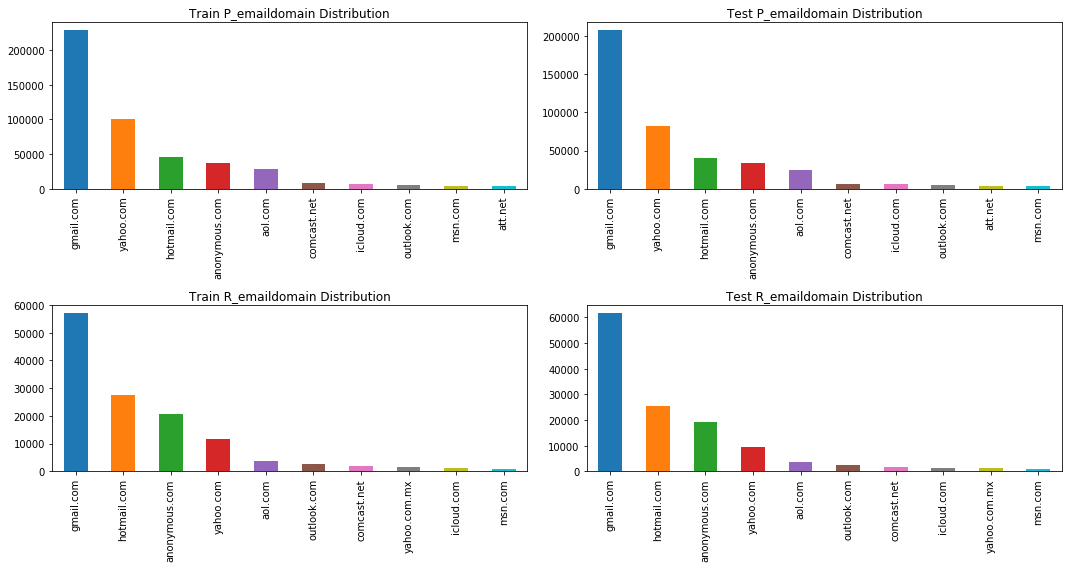

In [25]:
fig,ax=plt.subplots(2,2,figsize=(15,8))
train['P_emaildomain'].value_counts()[:10].plot.bar(ax=ax[0,0])
ax[0,0].set_title('Train P_emaildomain Distribution')

test['P_emaildomain'].value_counts()[:10].plot.bar(ax=ax[0,1])
ax[0,1].set_title('Test P_emaildomain Distribution')

train['R_emaildomain'].value_counts()[:10].plot.bar(ax=ax[1,0])
ax[1,0].set_title('Train R_emaildomain Distribution')

test['R_emaildomain'].value_counts()[:10].plot.bar(ax=ax[1,1])
ax[1,1].set_title('Test R_emaildomain Distribution')

plt.tight_layout()

## <a id='23'>Distribution of C features across Train and Test</a> 

In [26]:
C_columns=[col for col in train.columns if 'C'==col[0]]
for c in C_columns:
    print(f'Number of unique entries in {c}:',train[c].nunique())

Number of unique entries in C1: 1657
Number of unique entries in C2: 1216
Number of unique entries in C3: 27
Number of unique entries in C4: 1260
Number of unique entries in C5: 319
Number of unique entries in C6: 1328
Number of unique entries in C7: 1103
Number of unique entries in C8: 1253
Number of unique entries in C9: 205
Number of unique entries in C10: 1231
Number of unique entries in C11: 1476
Number of unique entries in C12: 1199
Number of unique entries in C13: 1597
Number of unique entries in C14: 1108


In [27]:
def get_subplots(feature1,feature2):
    fig,ax=plt.subplots(2,2,figsize=(15,8))
    sns.distplot(train[train['isFraud']==0][feature1],ax=ax[0,0],hist=False,label='NonFraud')
    sns.distplot(train[train['isFraud']==1][feature1],ax=ax[0,0],hist=False,label='Fraud')
    ax[0,0].set_title(f'Fraud and NonFraud {feature1} Distribution')

    sns.distplot(test[feature1],ax=ax[0,1],hist=False,label='Test')
    sns.distplot(train[feature1],ax=ax[0,1],hist=False,label='Train')
    ax[0,1].set_title(f'Test and Train {feature1} Distribution')

    sns.distplot(train[train['isFraud']==0][feature2],ax=ax[1,0],hist=False,label='NonFraud')
    sns.distplot(train[train['isFraud']==1][feature2],ax=ax[1,0],hist=False,label='Fraud')
    ax[1,0].set_title(f'Fraud and NonFraud {feature2} Distribution')

    sns.distplot(test[feature2],ax=ax[1,1],hist=False,label='Test')
    sns.distplot(train[feature2],ax=ax[1,1],hist=False,label='Train')
    ax[1,1].set_title(f'Test and Train {feature2} Distribution')

    plt.tight_layout()


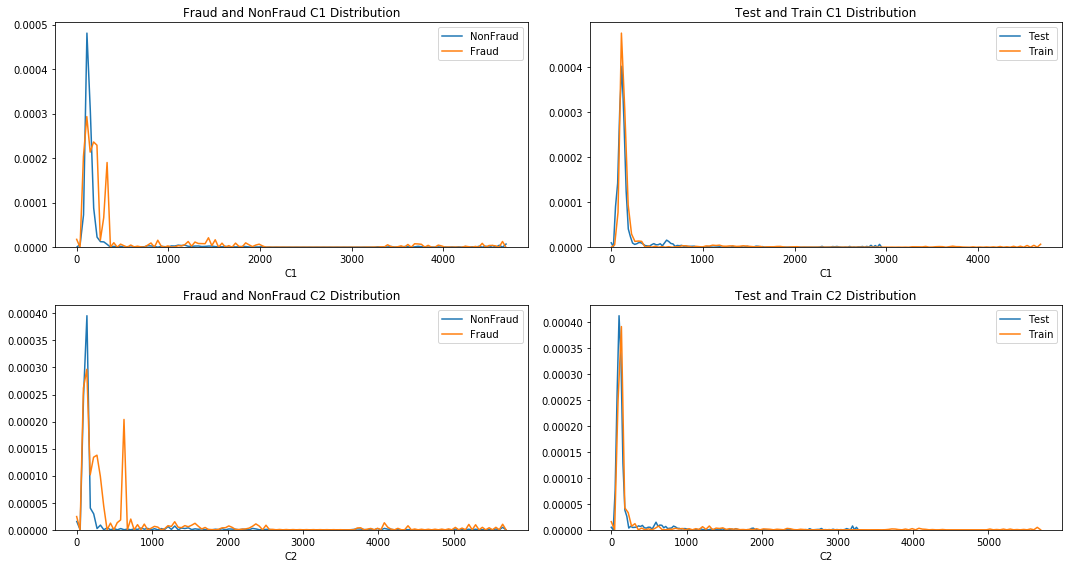

In [28]:
get_subplots('C1','C2')

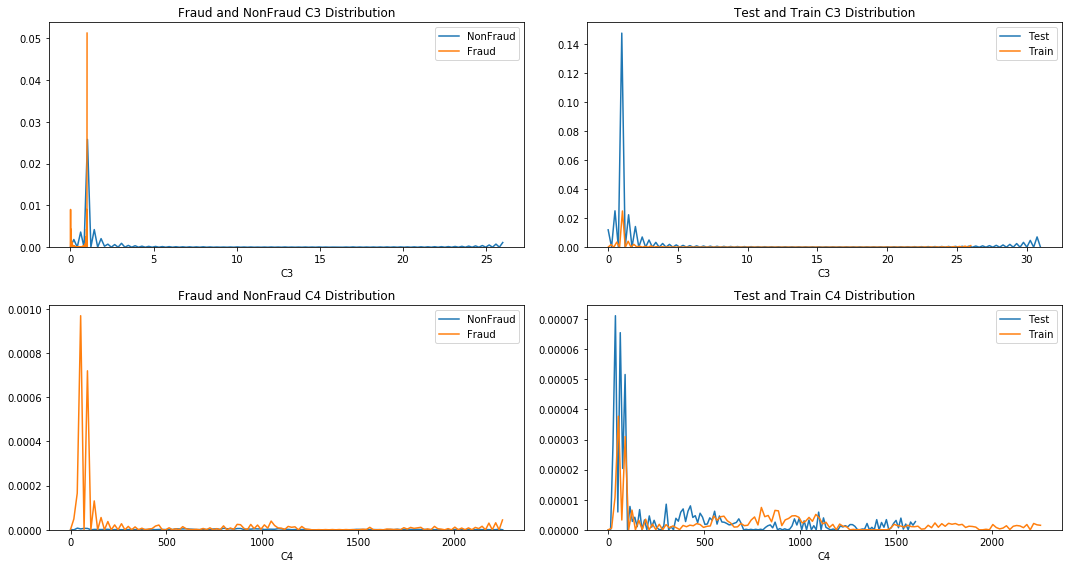

In [29]:
get_subplots('C3','C4')

C4 seems very much useful for nonfraud and fraud distinction because its distribution is very different for those two categories.

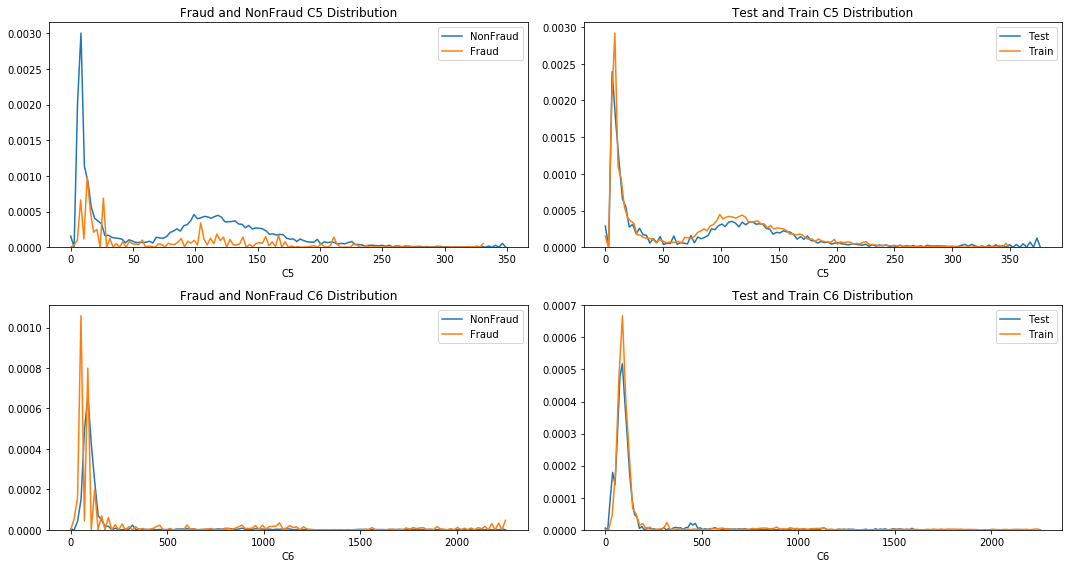

In [30]:
get_subplots('C5','C6')

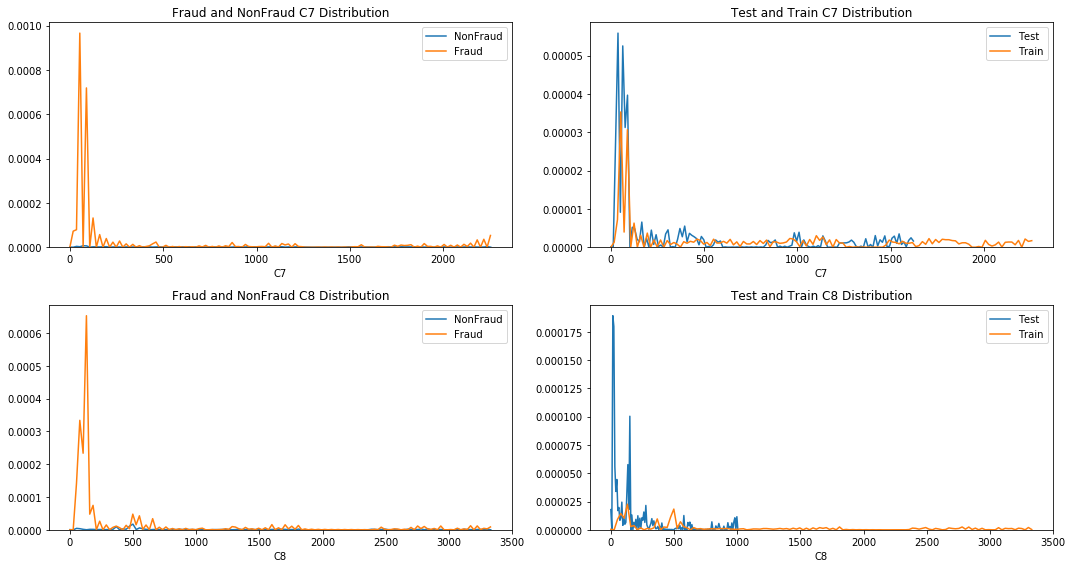

In [31]:
get_subplots('C7','C8')

C8 and C7 have very different distribution in case of Fraud and NonFraud categories. So they might be useful. But again, C8 distribution in test and train is also very different. We will try dropping and not dropping it. 

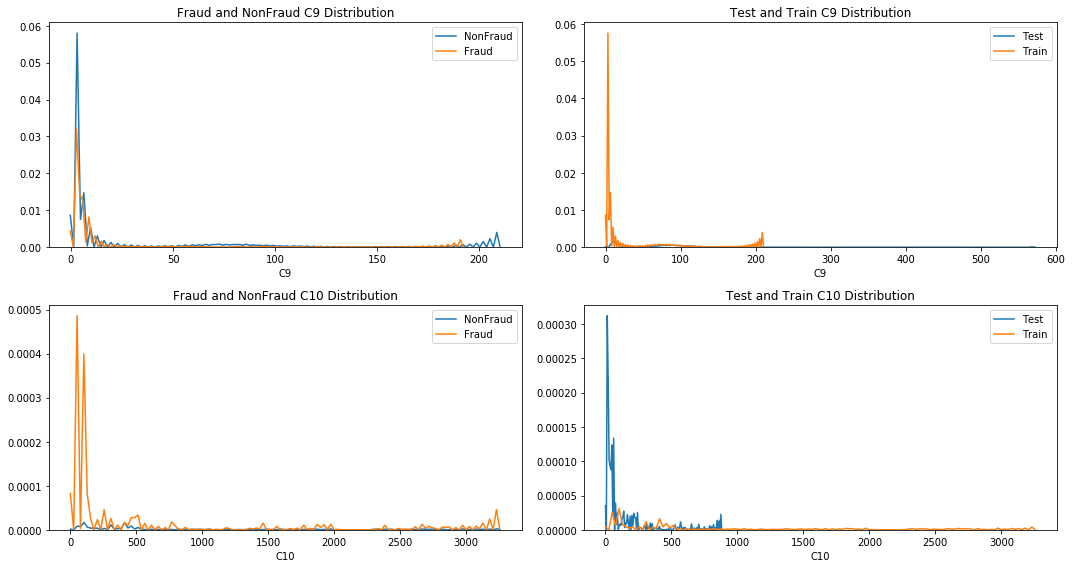

In [32]:
get_subplots('C9','C10')

C10 can be useful for distinction. But its distribution in test and train is very different as well. Same in case of C9. But I think it can be definitely dropped because its distribution in case of fraud and nonfraud is almost same.

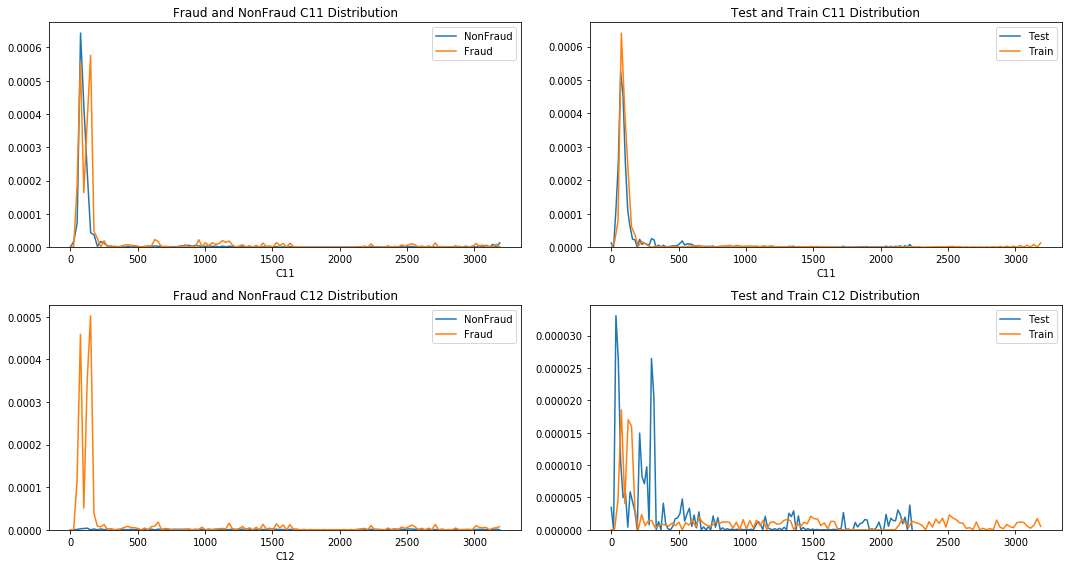

In [33]:
get_subplots('C11','C12')

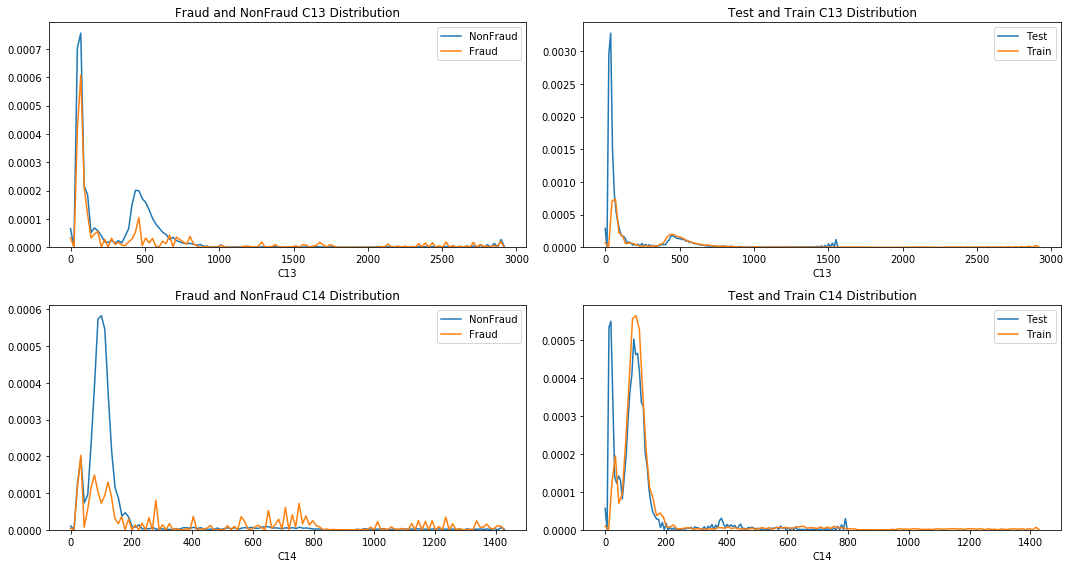

In [34]:
get_subplots('C13','C14')

## <a id='24'>Distribution of D features across Train and Test</a> 

In [35]:
train.columns[:50]

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4'],
      dtype='object')

In [36]:
D_cols=[col for col in train.columns if col[0]=='D']
for d in D_cols:
    print(f'Number of unique entries in {d}:',train[d].nunique())

Number of unique entries in D1: 641
Number of unique entries in D2: 641
Number of unique entries in D3: 649
Number of unique entries in D4: 808
Number of unique entries in D5: 688
Number of unique entries in D6: 829
Number of unique entries in D7: 597
Number of unique entries in D8: 12353
Number of unique entries in D9: 24
Number of unique entries in D10: 818
Number of unique entries in D11: 676
Number of unique entries in D12: 635
Number of unique entries in D13: 577
Number of unique entries in D14: 802
Number of unique entries in D15: 859
Number of unique entries in DeviceType: 2
Number of unique entries in DeviceInfo: 1786


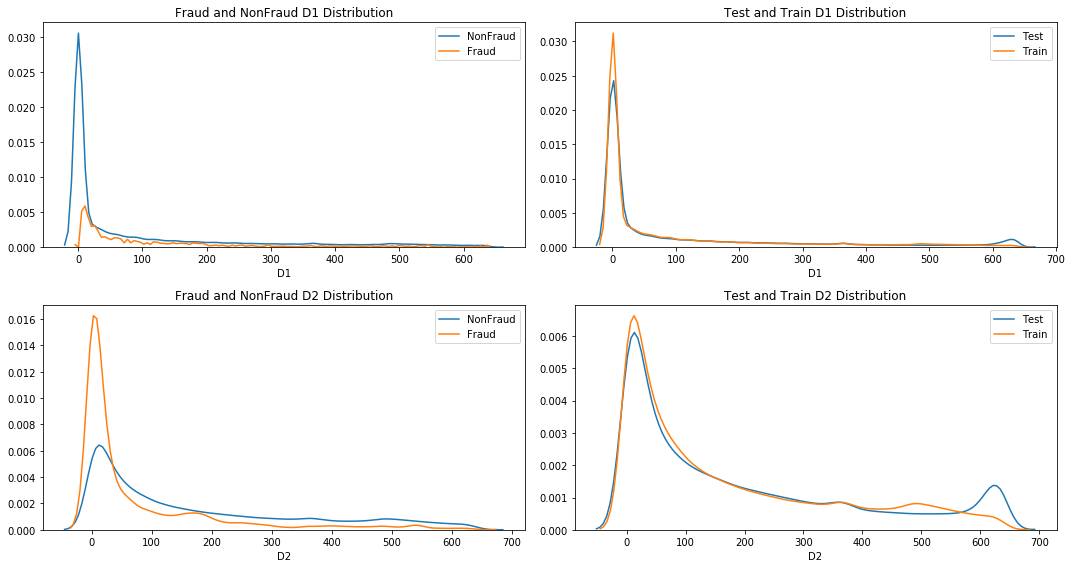

In [37]:
get_subplots('D1','D2')

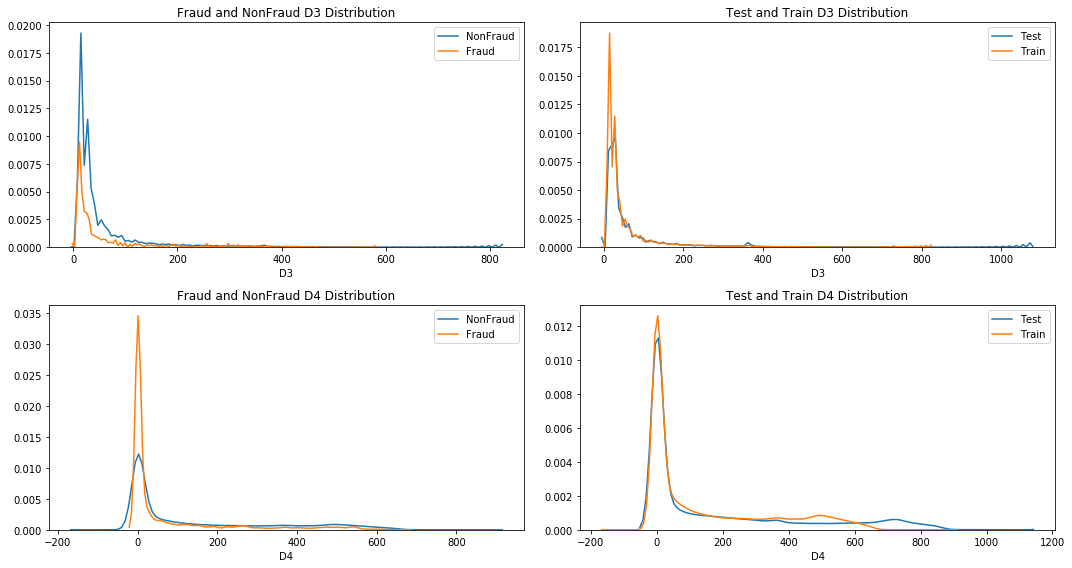

In [38]:
get_subplots('D3','D4')

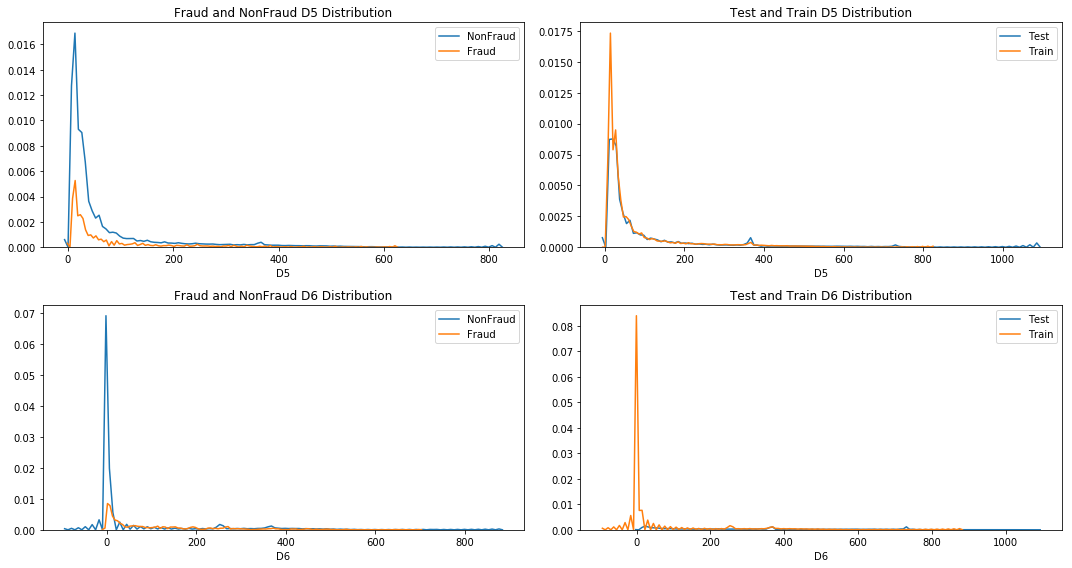

In [39]:
get_subplots('D5','D6')

In [40]:
def detailed_subplot(feature):
    fig,ax=plt.subplots(1,2,figsize=(15,5))
    sns.distplot(test[feature],hist=False,label='Test',ax=ax[0],color='orange')
    ax[0].set_title(f'Distribution of {feature} in Test')
    sns.distplot(train[feature],hist=False,label='Train',ax=ax[1])
    ax[1].set_title(f'Distribution of {feature} in Train')
    plt.tight_layout()

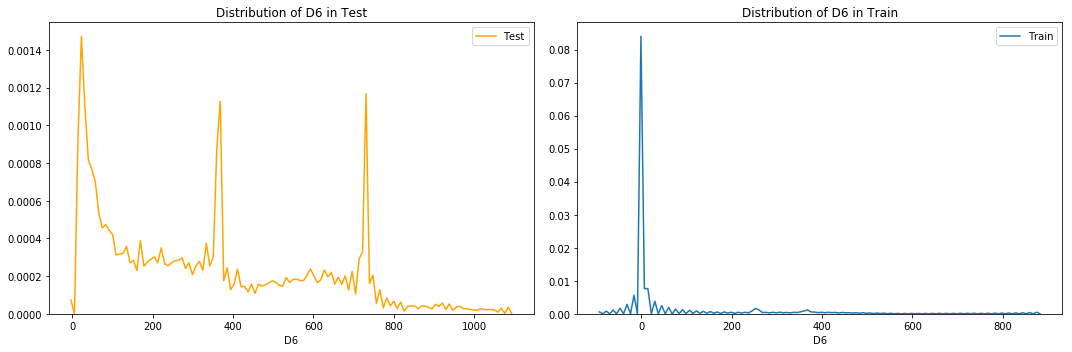

In [41]:
detailed_subplot('D6')

I think we can safely drop this column

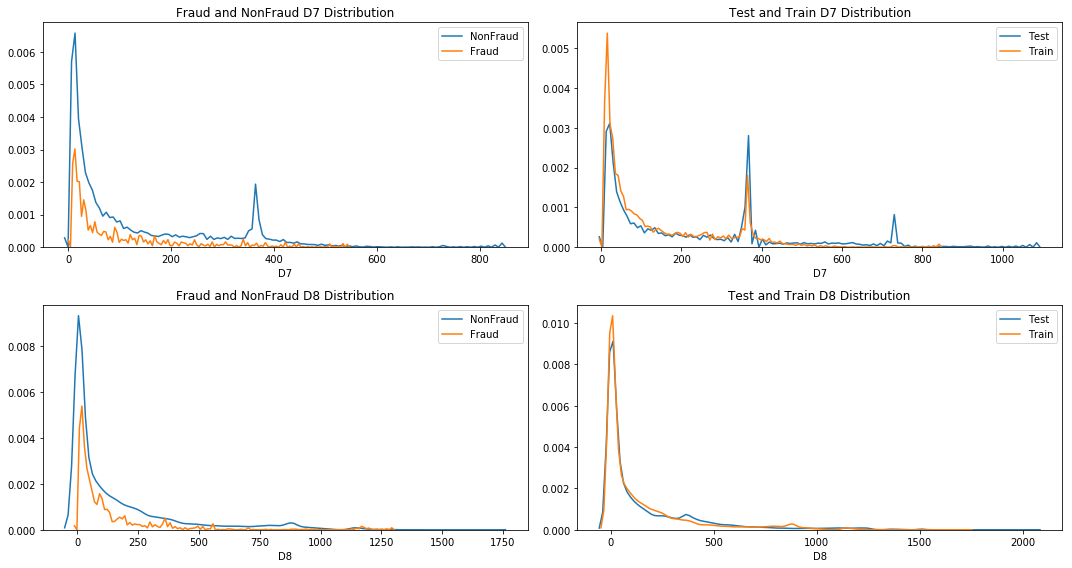

In [42]:
get_subplots('D7','D8')

In [43]:
print(train['D9'].value_counts())
print('*'*100)
print(test['D9'].value_counts())

0.791666    5388
0.833333    5273
0.750000    5147
0.708333    5132
0.666666    5069
0.875000    4857
0.916666    4694
0.958333    4411
0.625000    4380
0.000000    4190
0.041666    3826
0.083333    3726
0.583333    3644
0.125000    3308
0.166666    2786
0.541666    2327
0.208333    1913
0.500000    1278
0.250000    1067
0.458333     733
0.291666     663
0.416666     404
0.333333     387
0.375000     323
Name: D9, dtype: int64
****************************************************************************************************
0.791666    5111
0.708333    5106
0.750000    5033
0.666666    5021
0.833333    4939
0.875000    4805
0.916666    4503
0.625000    4415
0.958333    4179
0.000000    4062
0.041666    4043
0.083333    3841
0.583333    3781
0.125000    3534
0.166666    2760
0.541666    2393
0.208333    1839
0.500000    1346
0.250000    1146
0.458333     795
0.291666     562
0.416666     414
0.333333     412
0.375000     298
Name: D9, dtype: int64


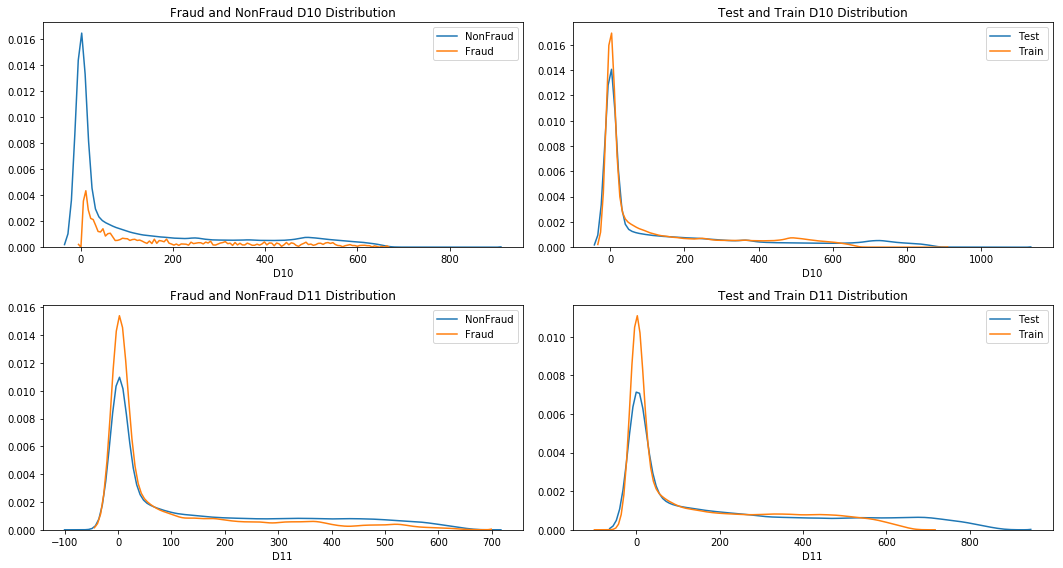

In [44]:
get_subplots('D10','D11')

 Drop some columns : From https://www.kaggle.com/jazivxt/safe-box/notebook

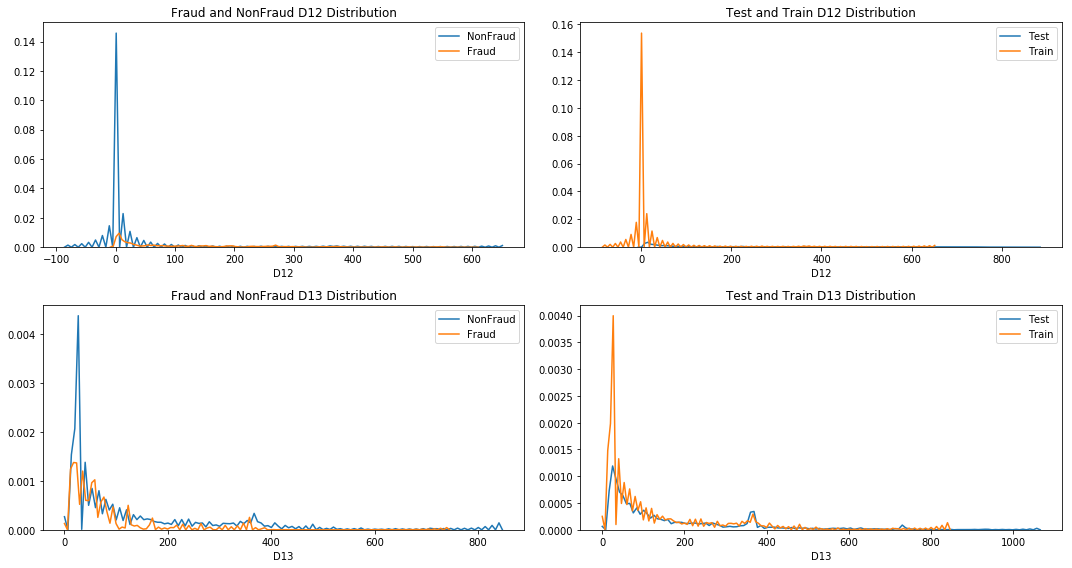

In [45]:
get_subplots('D12','D13')

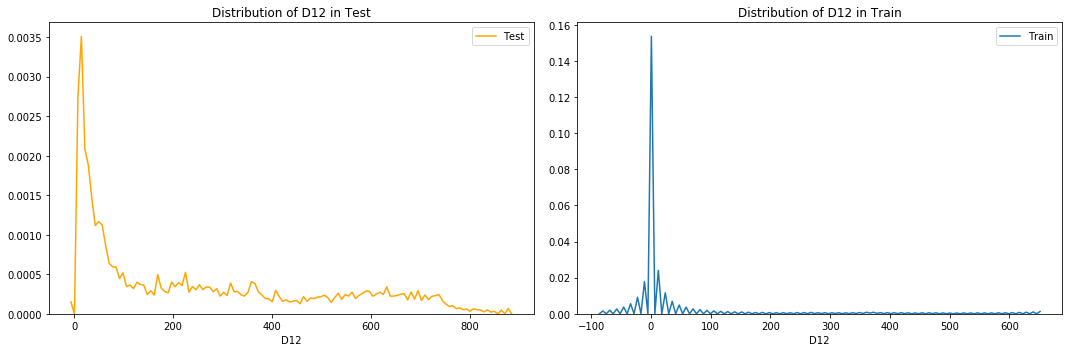

In [46]:
detailed_subplot('D12')

We can try dropping this column.

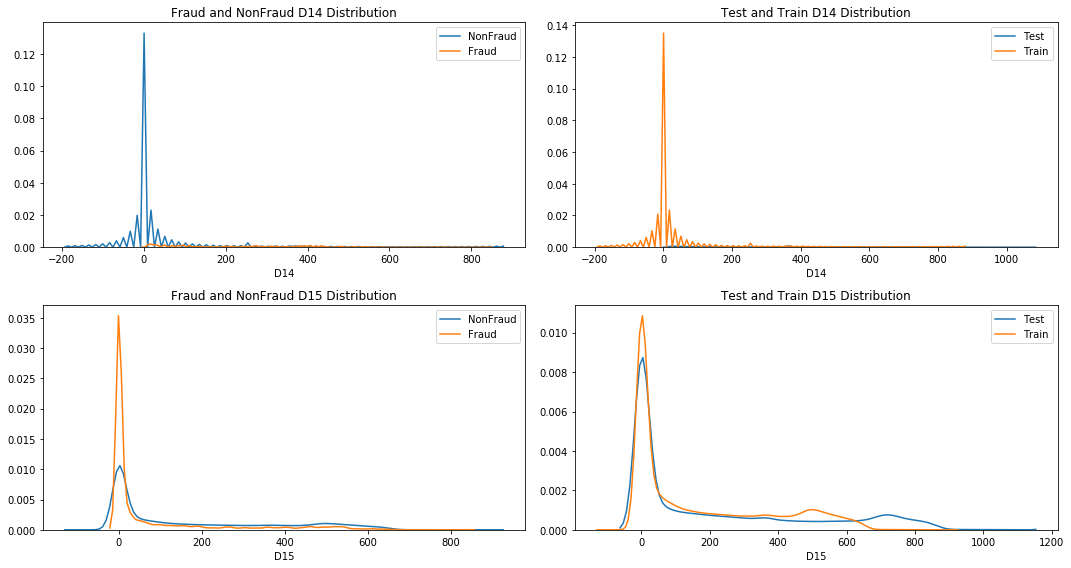

In [47]:
get_subplots('D14','D15')

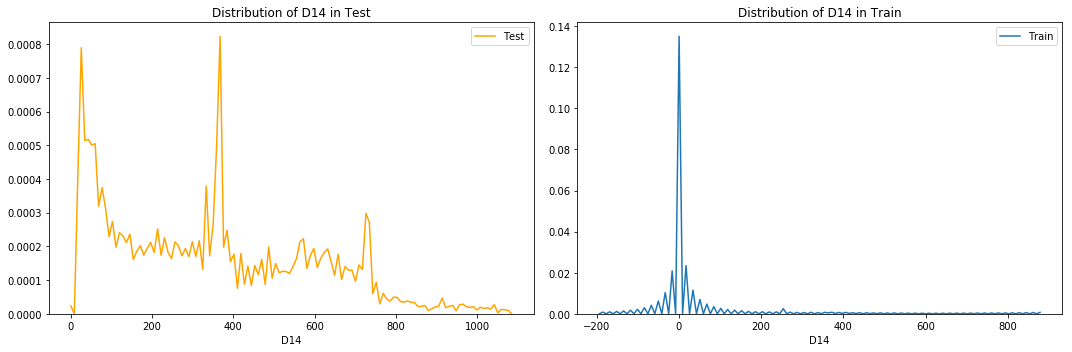

In [48]:
detailed_subplot('D14')

We can try dropping this.

## <a id='25'>Distribution of M features across Train and Test</a> 

In [49]:
M_cols=[col for col in train.columns if col[0]=='M']
for m in M_cols:
    print(f'Number of unique entries in {m}:',train[m].nunique())

Number of unique entries in M1: 2
Number of unique entries in M2: 2
Number of unique entries in M3: 2
Number of unique entries in M4: 3
Number of unique entries in M5: 2
Number of unique entries in M6: 2
Number of unique entries in M7: 2
Number of unique entries in M8: 2
Number of unique entries in M9: 2


In [50]:
def get_bar_subplots(feature1,feature2,top=10,incre=0):
    fig,ax=plt.subplots(2,2,figsize=(15,8))
    train[feature1].value_counts()[:top].plot.bar(ax=ax[0,0])
    ax[0,0].set_title(f'Train {feature1} Distribution')
    
    test[feature1].value_counts()[:top].plot.bar(ax=ax[0,1])
    ax[0,1].set_title(f'Test {feature1} Distribution')

    train[feature2].value_counts()[:top+incre].plot.bar(ax=ax[1,0])
    ax[1,0].set_title(f'Train {feature2} Distribution')

    test[feature2].value_counts()[:top+incre].plot.bar(ax=ax[1,1])
    ax[1,1].set_title(f'Test {feature2} Distribution')

    plt.tight_layout()


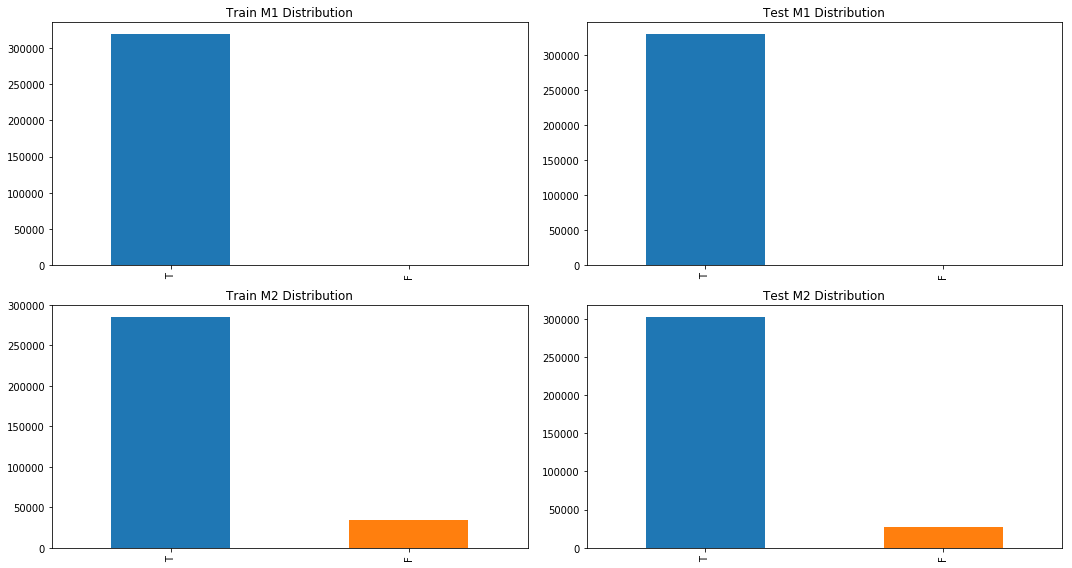

In [51]:
get_bar_subplots('M1','M2',2)

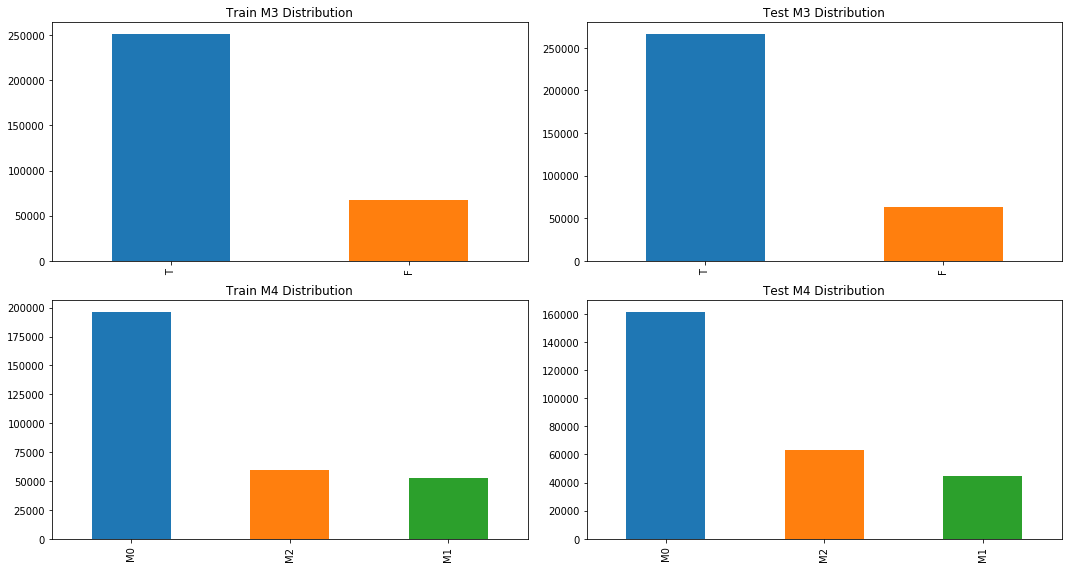

In [52]:
get_bar_subplots('M3','M4',2,1)

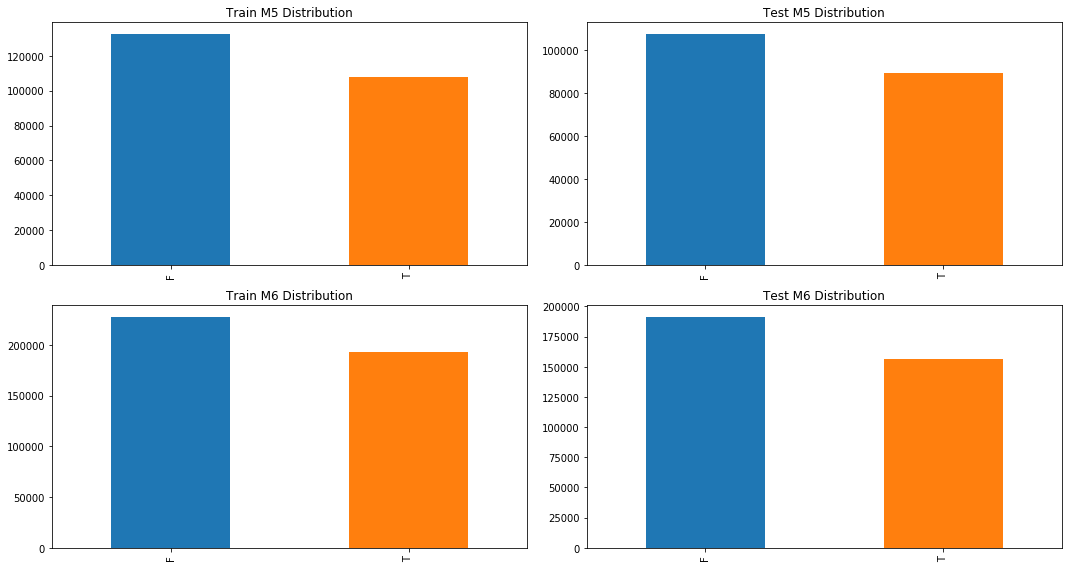

In [53]:
get_bar_subplots('M5','M6',2)

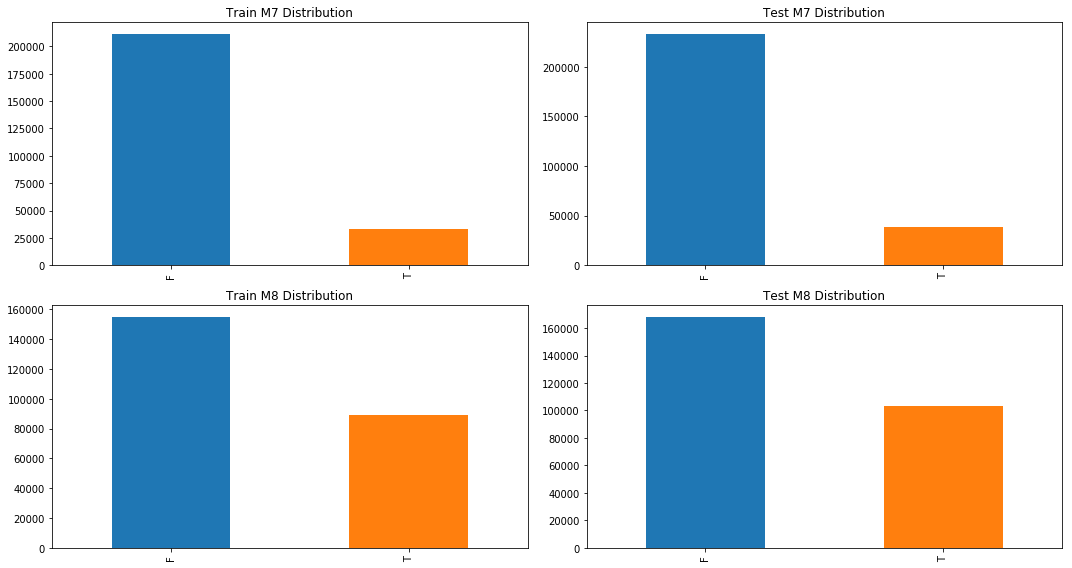

In [54]:
get_bar_subplots('M7','M8',2)

Text(0.5, 1.0, 'Test M9 Distribution')

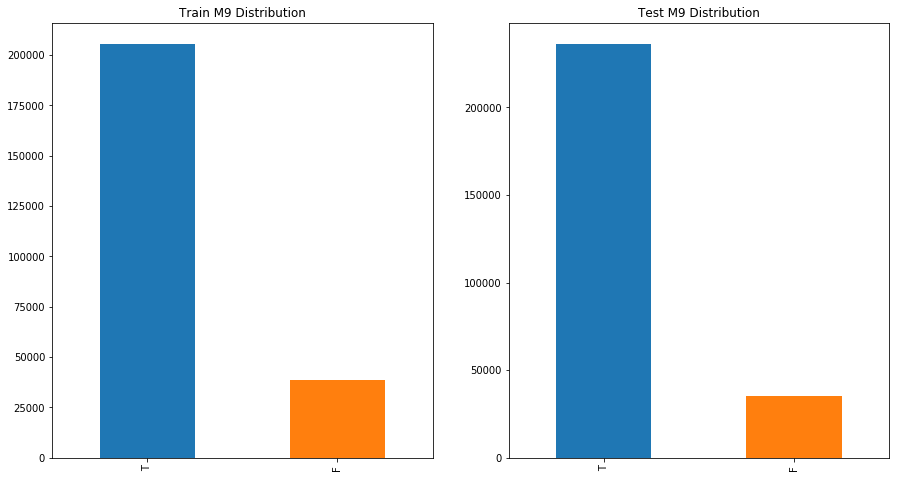

In [55]:
fig,ax=plt.subplots(1,2,figsize=(15,8))
train['M9'].value_counts().plot.bar(ax=ax[0])
ax[0].set_title('Train M9 Distribution')
    
test['M9'].value_counts().plot.bar(ax=ax[1])
ax[1].set_title('Test M9 Distribution')

In [56]:
train.columns[50:100]

Index(['M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7',
       'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17',
       'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
       'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37',
       'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45'],
      dtype='object')

## <a id='26'>Distribution of V features across Train and Test</a> 

In [57]:
V_cols=[col for col in train.columns if col[0]=='V']
V_type=[train[col].dtype for col in V_cols]
print(set(V_type))
print(len(V_cols))

{dtype('float64')}
339


In [58]:
unique=[(col,train[col].nunique()) for col in V_cols]
sorted_unique=sorted(unique,key=lambda x: x[1])
sorted_unique[:50]

[('V1', 2),
 ('V14', 2),
 ('V41', 2),
 ('V65', 2),
 ('V88', 2),
 ('V107', 2),
 ('V305', 2),
 ('V68', 3),
 ('V89', 3),
 ('V94', 3),
 ('V12', 4),
 ('V27', 4),
 ('V28', 4),
 ('V35', 4),
 ('V117', 4),
 ('V118', 4),
 ('V119', 4),
 ('V120', 4),
 ('V121', 4),
 ('V122', 4),
 ('V10', 5),
 ('V75', 5),
 ('V241', 5),
 ('V11', 6),
 ('V21', 6),
 ('V29', 6),
 ('V36', 6),
 ('V48', 6),
 ('V49', 6),
 ('V50', 6),
 ('V53', 6),
 ('V69', 6),
 ('V90', 6),
 ('V141', 6),
 ('V240', 6),
 ('V4', 7),
 ('V5', 7),
 ('V13', 7),
 ('V25', 7),
 ('V33', 7),
 ('V46', 7),
 ('V51', 7),
 ('V54', 7),
 ('V57', 7),
 ('V61', 7),
 ('V70', 7),
 ('V71', 7),
 ('V76', 7),
 ('V91', 7),
 ('V114', 7)]

In [59]:
def get_bar_subplots(feature1,feature2):
    fig,ax=plt.subplots(2,2,figsize=(15,8))
    train[feature1].value_counts().plot.bar(ax=ax[0,0])
    ax[0,0].set_title(f'Train {feature1} Distribution')
    
    test[feature1].value_counts().plot.bar(ax=ax[0,1])
    ax[0,1].set_title(f'Test {feature1} Distribution')

    train[feature2].value_counts().plot.bar(ax=ax[1,0])
    ax[1,0].set_title(f'Train {feature2} Distribution')

    test[feature2].value_counts().plot.bar(ax=ax[1,1])
    ax[1,1].set_title(f'Test {feature2} Distribution')

    plt.tight_layout()

I skimmed through the distribution of every V_column and removed the columns which satisfied following criteria:
1. **extreme outliers in case of test or train** or 
2. **the Density of the major peak of test and train had very significant mismatch** or 
3. **test or train had lot of extra unique values compared to each other. **

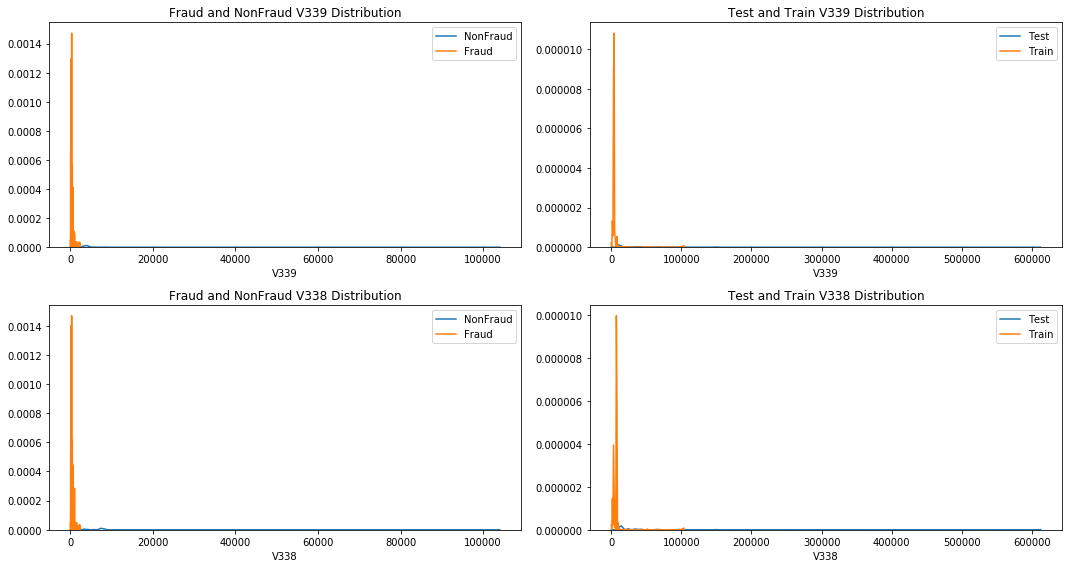

In [60]:
get_subplots('V339','V338')

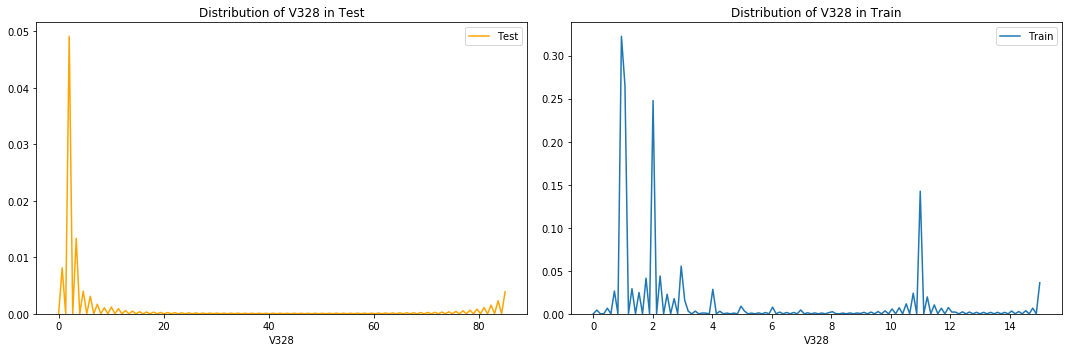

In [61]:
detailed_subplot('V328')

## <a id='27'>Distribution of ID features across Train and Test</a> 

Same as done with other features. All the distributions are similar in test and train. So no ID column is dropped.

In [62]:
train.columns[350:]

Index(['V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V302', 'V303', 'V304',
       'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313',
       'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'V322',
       'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331',
       'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339', 'id_01',
       'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09',
       'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17',
       'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33',
       'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'],
      dtype='object')

In [63]:
i_cols=[col for col in train.columns if col[0]=='i']
unique_val=[(col,train[col].nunique()) for col in i_cols]
unique_val

[('isFraud', 2),
 ('id_01', 77),
 ('id_02', 115655),
 ('id_03', 24),
 ('id_04', 15),
 ('id_05', 93),
 ('id_06', 101),
 ('id_07', 84),
 ('id_08', 94),
 ('id_09', 46),
 ('id_10', 62),
 ('id_11', 365),
 ('id_12', 2),
 ('id_13', 54),
 ('id_14', 25),
 ('id_15', 3),
 ('id_16', 2),
 ('id_17', 104),
 ('id_18', 18),
 ('id_19', 522),
 ('id_20', 394),
 ('id_21', 490),
 ('id_22', 25),
 ('id_23', 3),
 ('id_24', 12),
 ('id_25', 341),
 ('id_26', 95),
 ('id_27', 2),
 ('id_28', 2),
 ('id_29', 2),
 ('id_30', 75),
 ('id_31', 130),
 ('id_32', 4),
 ('id_33', 260),
 ('id_34', 4),
 ('id_35', 2),
 ('id_36', 2),
 ('id_37', 2),
 ('id_38', 2)]

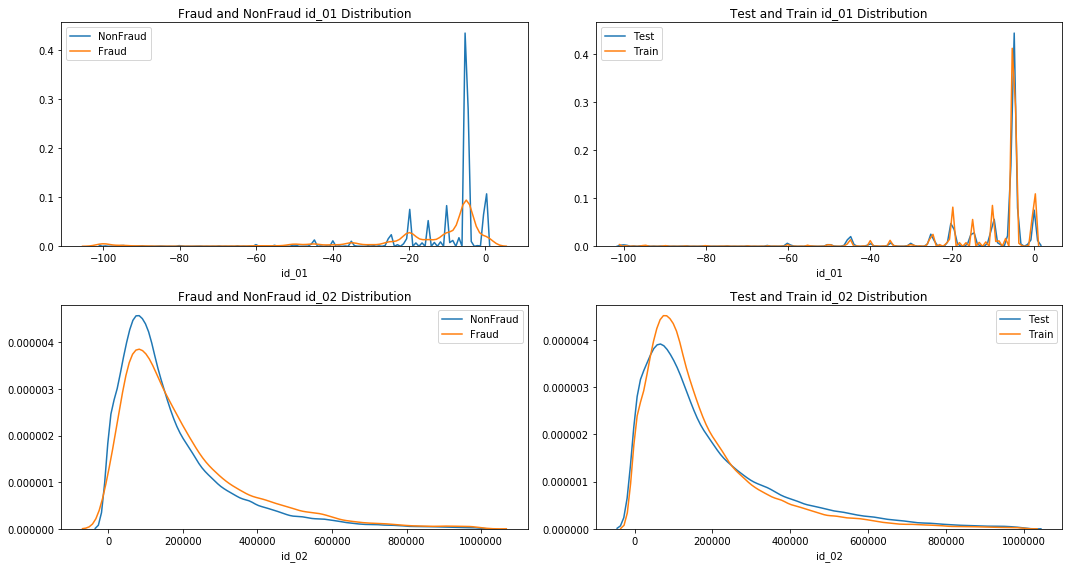

In [64]:
get_subplots('id_01','id_02')

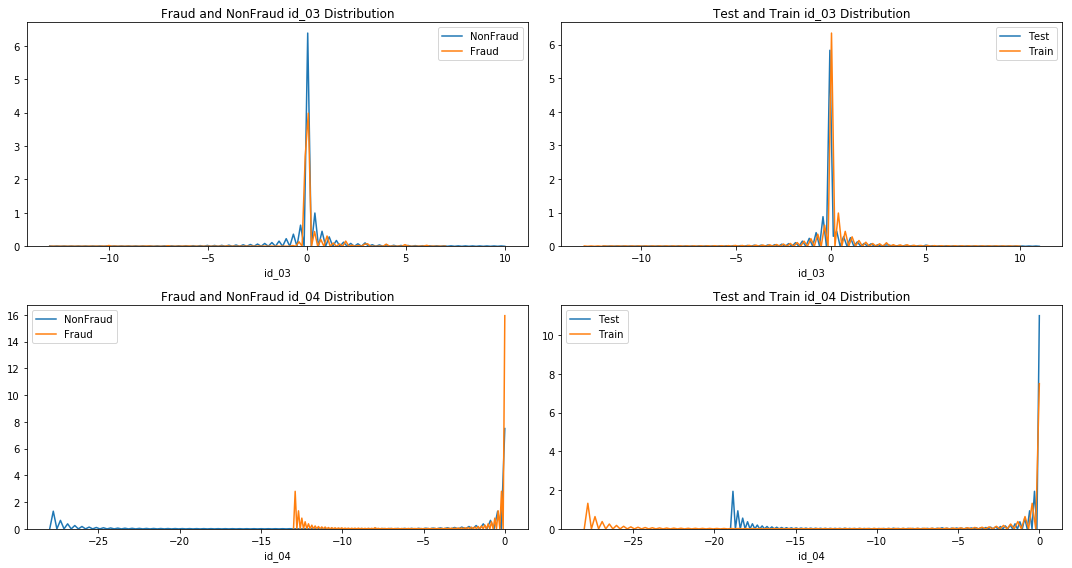

In [65]:
get_subplots('id_03','id_04')

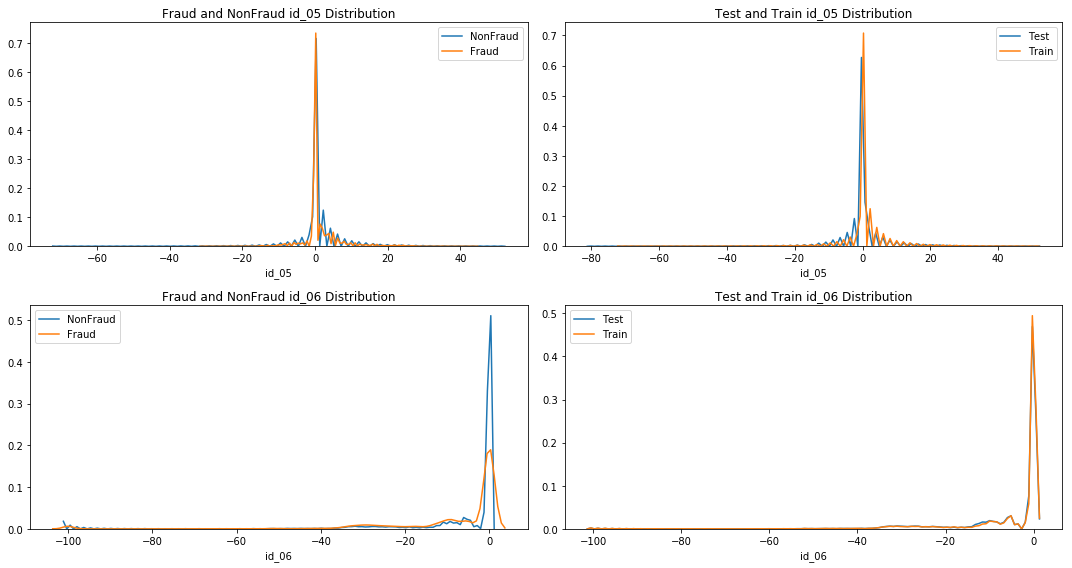

In [66]:
get_subplots('id_05','id_06')

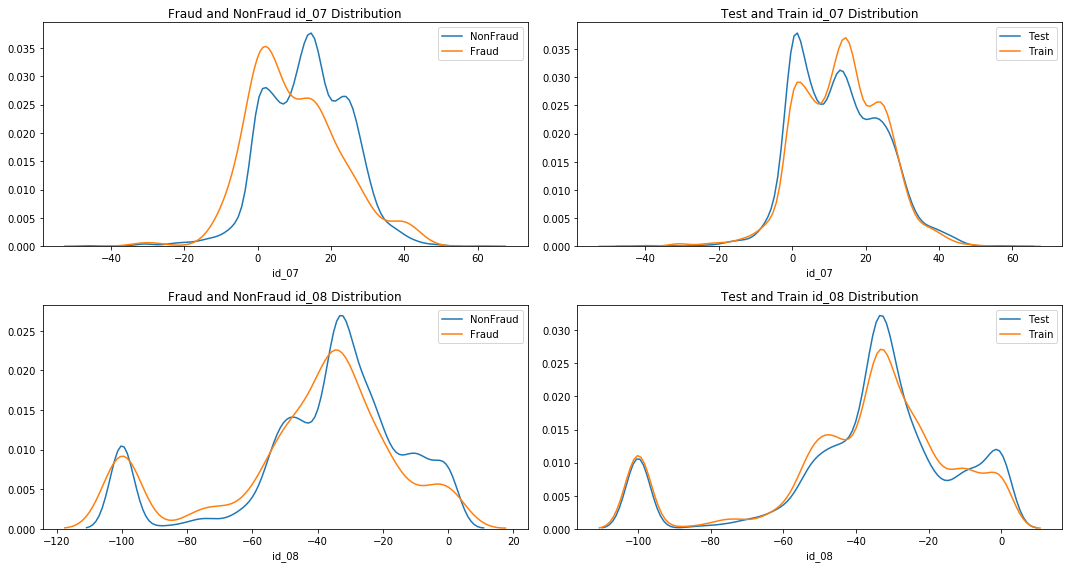

In [67]:
get_subplots('id_07','id_08')

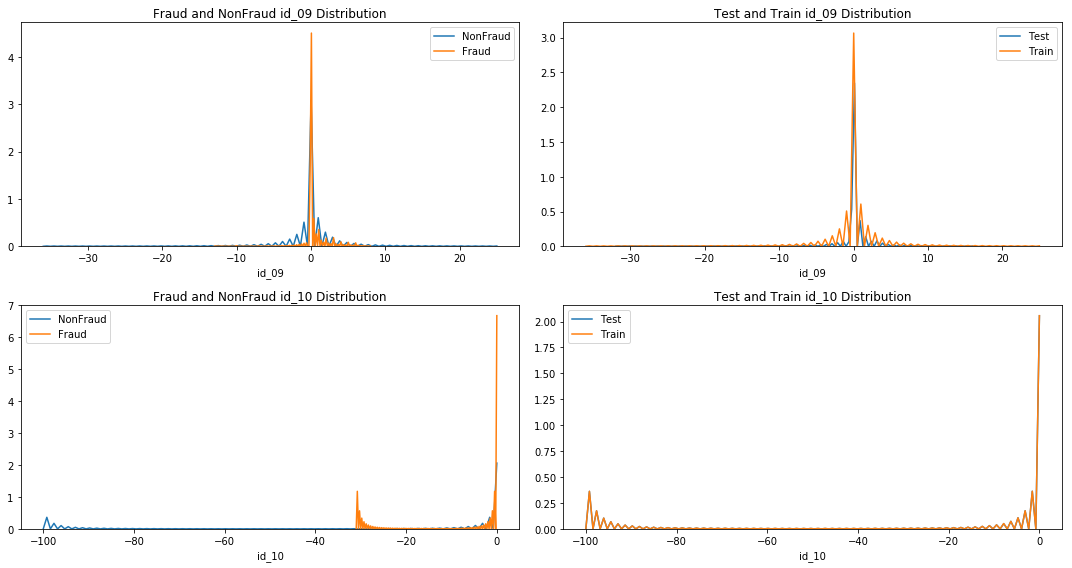

In [68]:
get_subplots('id_09','id_10')

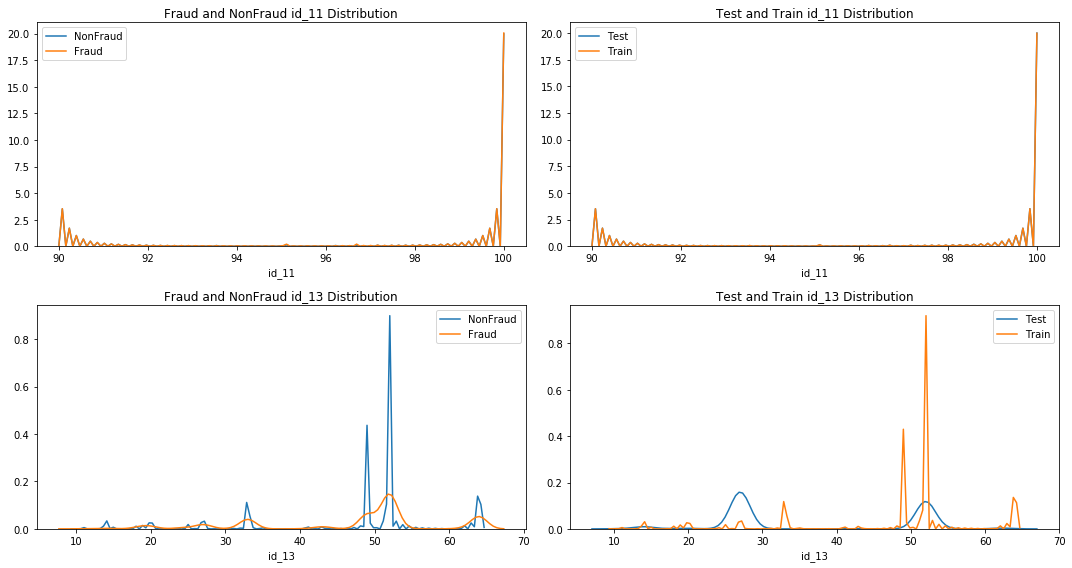

In [69]:
get_subplots('id_11','id_13')

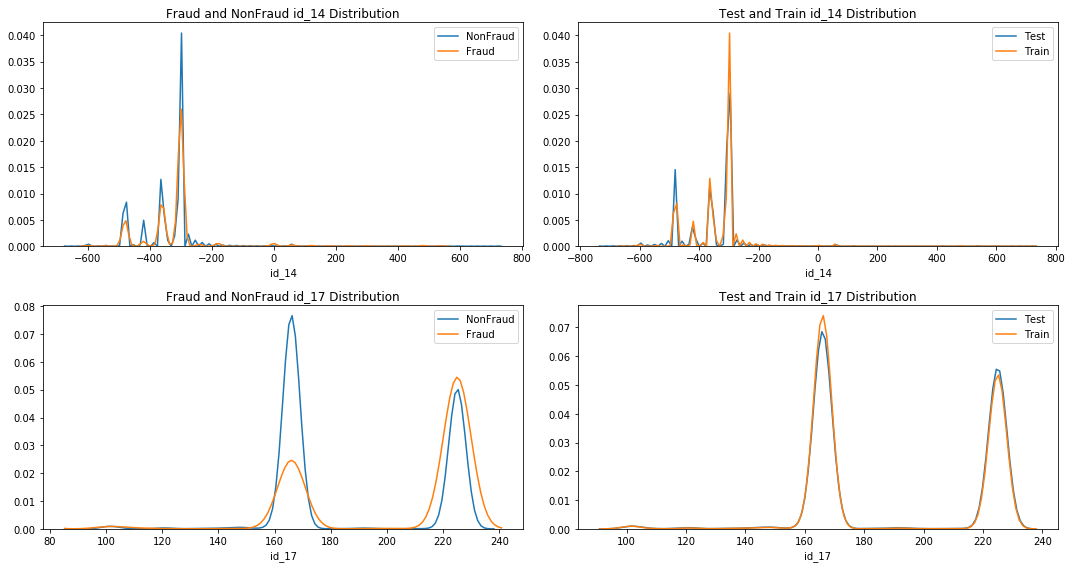

In [70]:
get_subplots('id_14','id_17')

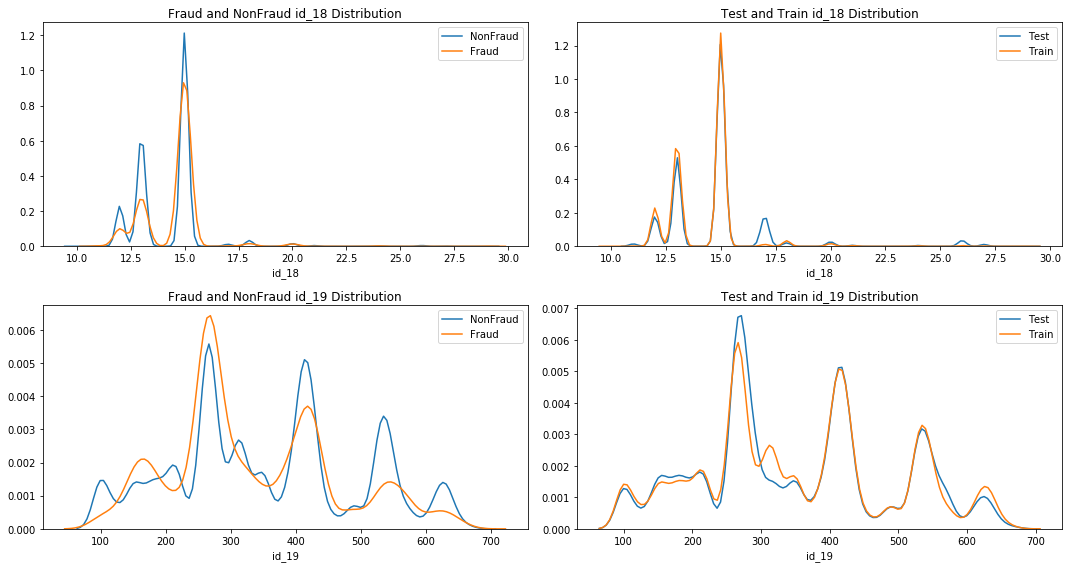

In [71]:
get_subplots('id_18','id_19')

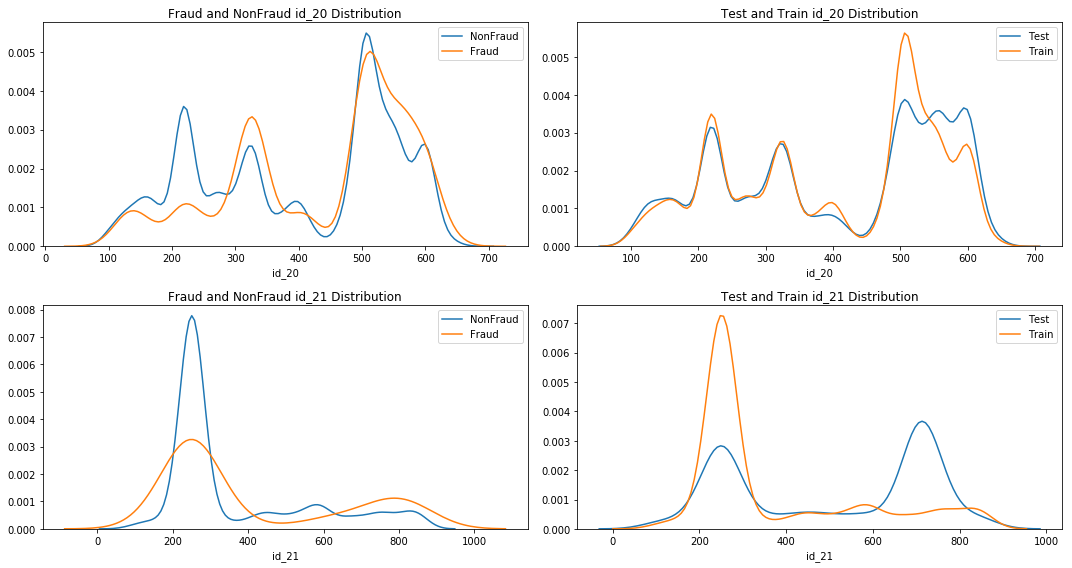

In [72]:
get_subplots('id_20','id_21')

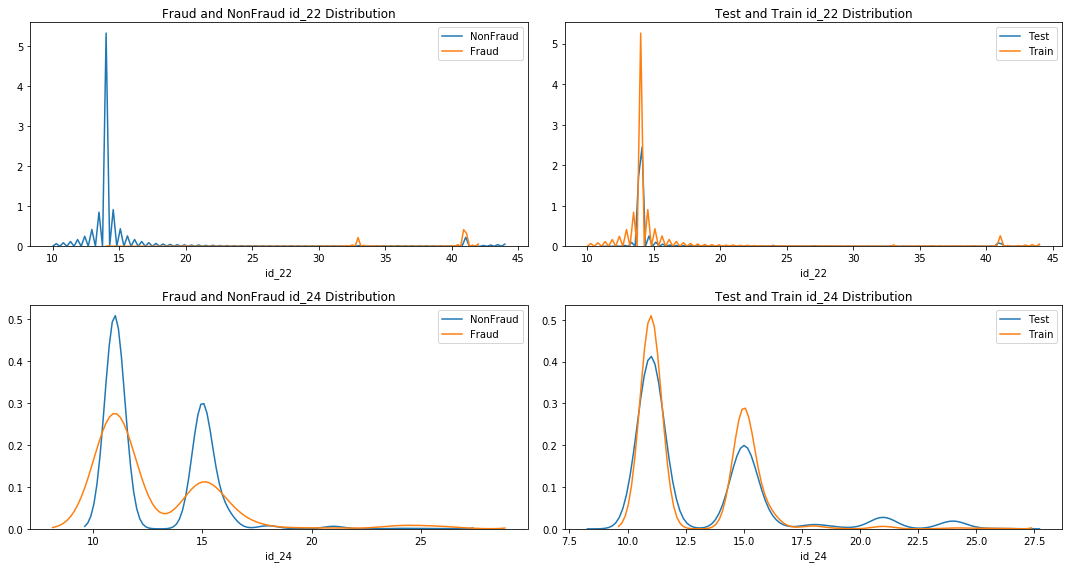

In [73]:
get_subplots('id_22','id_24')

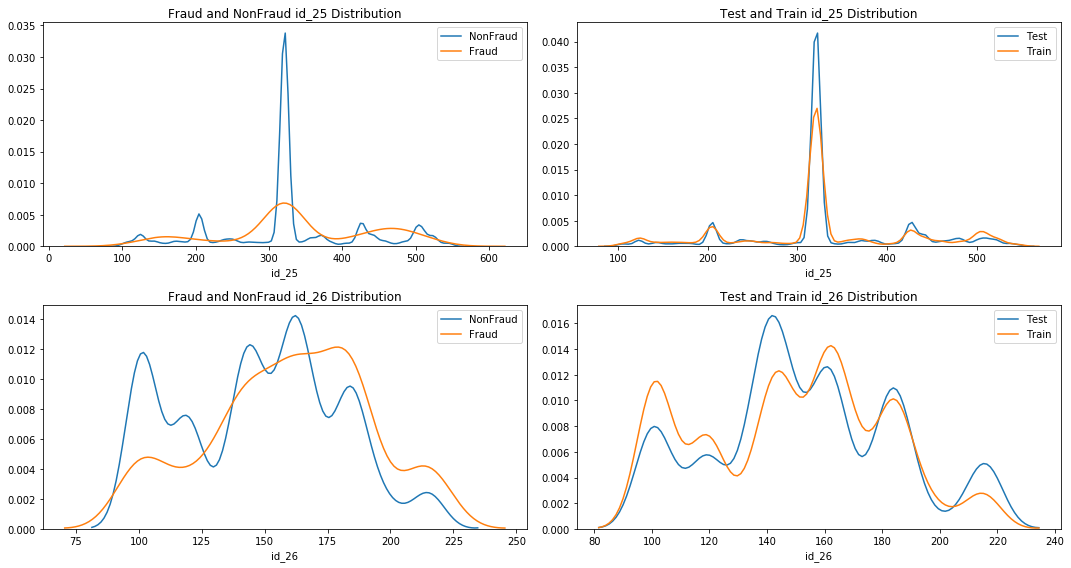

In [74]:
get_subplots('id_25','id_26')

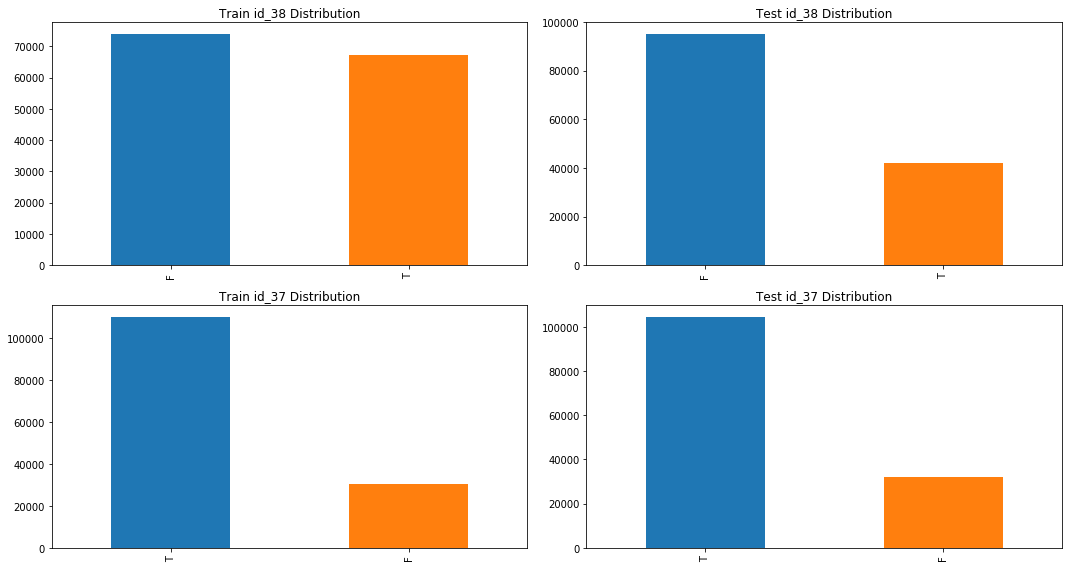

In [75]:
get_bar_subplots('id_38','id_37')

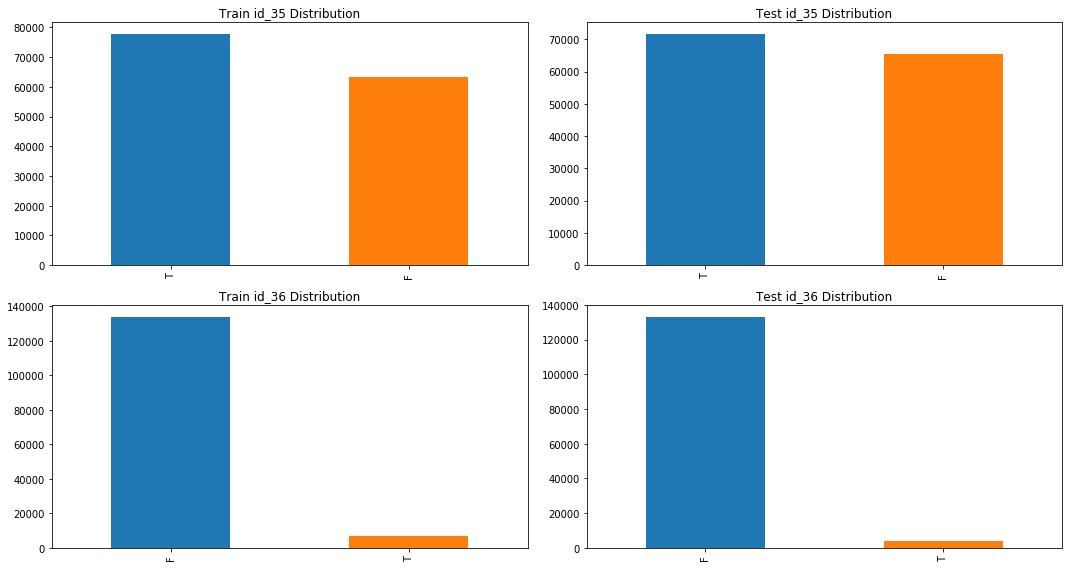

In [76]:
get_bar_subplots('id_35','id_36')

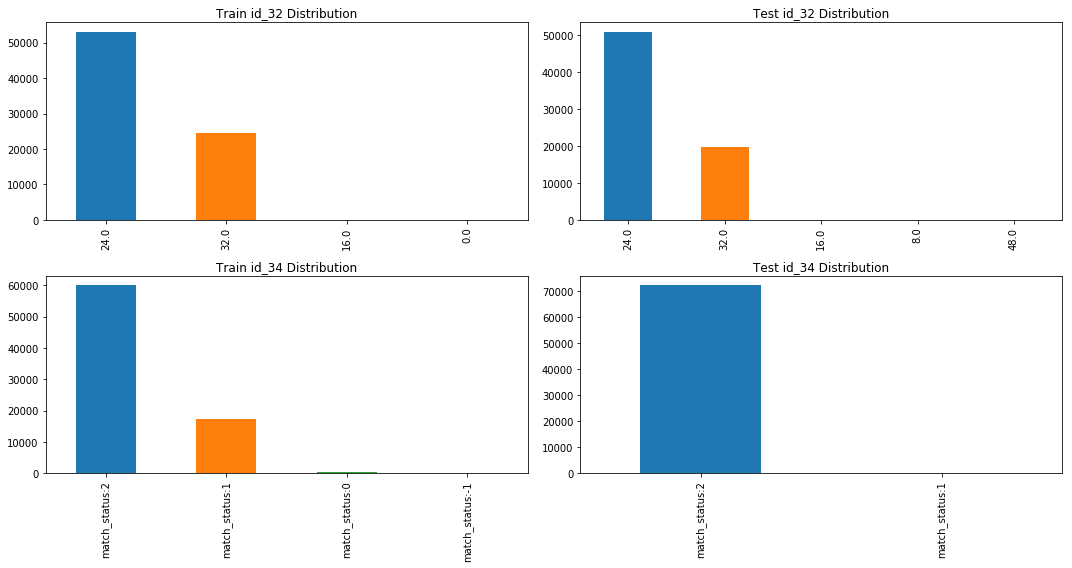

In [77]:
get_bar_subplots('id_32','id_34')

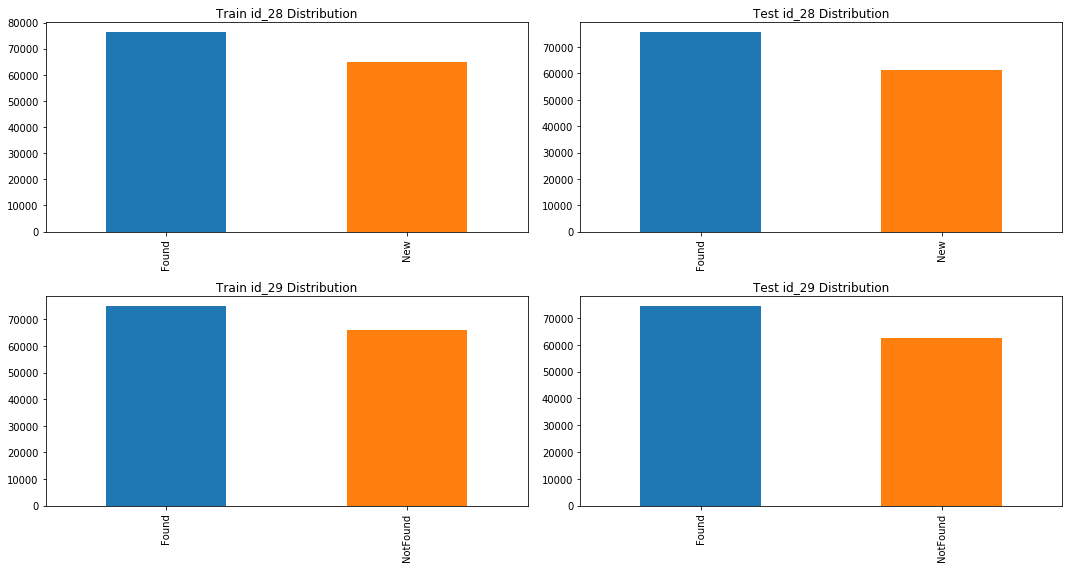

In [78]:
get_bar_subplots('id_28','id_29')

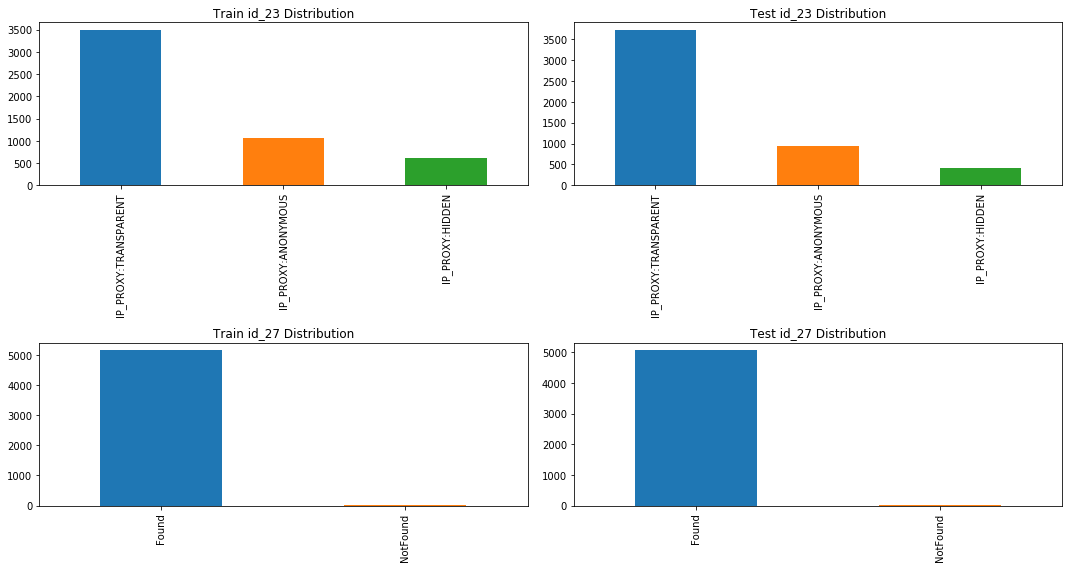

In [79]:
get_bar_subplots('id_23','id_27')

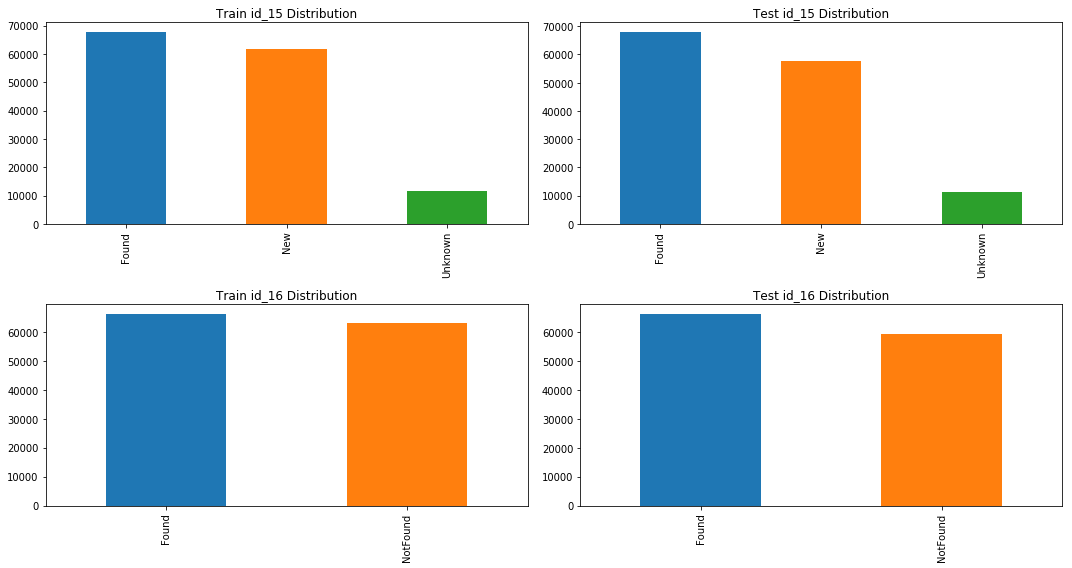

In [80]:
get_bar_subplots('id_15','id_16')

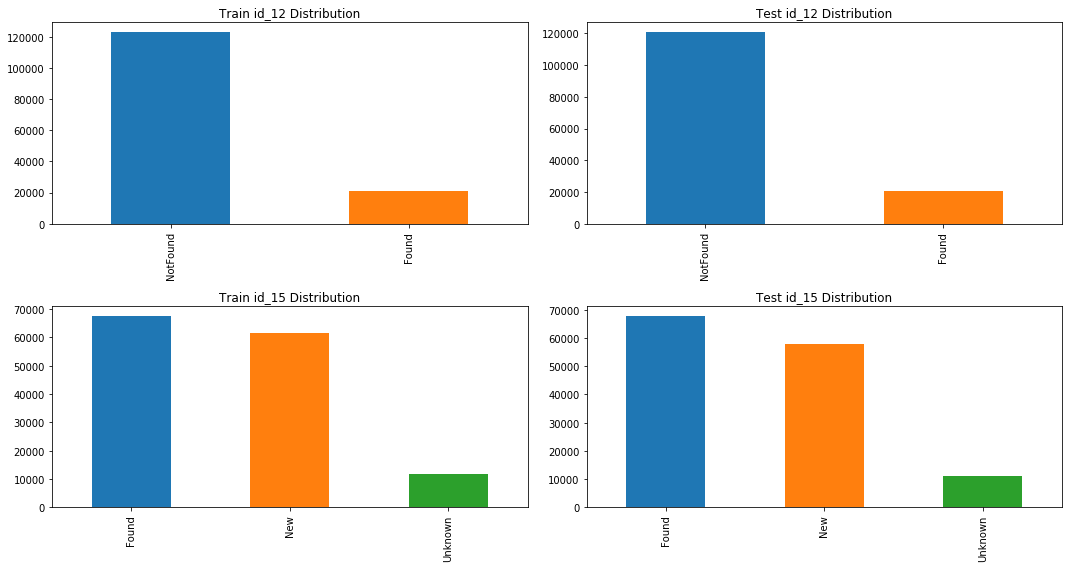

In [81]:
get_bar_subplots('id_12','id_15')

# <a id='3'>Dropping Columns</a> 

In [82]:
drop_cols=['dist2','C8','C9','C10','D6','D12','V27','V28','V45','V70','V71','V77','V78','V86','V87','V89','V91','V92','V95','V96','V97',
          'V101','V102','V103','V107','V126','V127','V128','V130','V131','V132','V133','V134','V135','V136','V137','V143','V145','V150',
          'V159','V160','V164','V165','V166','V167','V168','V171','V176','V177','V178','V179','V181','V182','V183','V190','V199','V202',
          'V203','V204','V207','V211','V212','V213','V214','V215','V216','V221','V226','V227','V228','V230','V234','V240','V241','V245',
          'V246','V255','V256','V257','V258','V259','V261','V263','V264','V265','V270','V271','V272','V273','V274','V275','V276','V277',
          'V278','V279','V280','V291','V292','V293','V294','V295','V297','V306','V307','V308','V310','V312','V316','V317','V318','V319',
          'V320','V321','V322','V323','V324','V331','V332','V333','V338','V339','TransactionDT','TransactionID']

train=train.drop(drop_cols,1)
test=test.drop(drop_cols,1)
train['TransactionAmt']=np.log(train['TransactionAmt'])
test['TransactionAmt']=np.log(test['TransactionAmt'])

In [83]:

# drop_col = ['TransactionDT','TransactionID','V300', 'V309', 'V111', 'C3', 'V124', 'V106', 'V125', 'V315', 'V134', 'V102', 'V123', 
#             'V316', 'V113', 'V136', 'V305', 'V110', 'V299', 'V289', 'V286', 'V318', 'V103', 'V304', 'V116', 'V298', 
#             'V284', 'V293', 'V137', 'V295', 'V301', 'V104', 'V311', 'V115', 'V109', 'V119', 'V321', 'V114', 'V133', 
#             'V122', 'V319', 'V105', 'V112', 'V118', 'V117', 'V121', 'V108', 'V135', 'V320', 'V303', 'V297', 'V120']

# drop_col=['TransactionDT','TransactionID']
# train=train.drop(drop_col,1)
# test=test.drop(drop_col,1)

# <a id='4'>Reducing memory size</a> 

In [84]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.3 µs


In [85]:
train=reduce_mem_usage(train)
test=reduce_mem_usage(test)

Memory usage of dataframe is 1425.70 MB
Memory usage after optimization is: 360.85 MB
Decreased by 74.7%
Memory usage of dataframe is 1222.25 MB
Memory usage after optimization is: 311.99 MB
Decreased by 74.5%


In [86]:
# obj_cols=[col for col in train.columns if train[col].dtype=='object']
# if 'isFraud' in obj_cols:
#     obj_cols.remove('isFraud')
    
# unique_values=sorted([(col,train[col].nunique()+test[col].nunique()) for col in obj_cols],key=lambda x: x[1],reverse=False)

In [87]:
# dummy_cols=[col[0] for col in unique_values[:18]]
# target=train['isFraud']
# train=train.drop('isFraud',1)
# ntrain=train.shape[0]
# print(train.shape)
# merged_data=pd.concat([train,test],axis=0,ignore_index=True)
# X=pd.get_dummies(merged_data,columns=dummy_cols)
# merged_data.drop(dummy_cols,axis=1,inplace=True)
# merged_data=pd.concat([merged_data,X],axis=1)
# del X
# train=merged_data[:ntrain]
# test=merged_data[ntrain:]
# print(train.shape)
# del merged_data
# gc.collect()

# <a id='5'>Feature Engineering</a> 

In [88]:
num_cols=[col for col in train.columns if (('float' in str(train[col].dtype)) or ('int' in str(train[col].dtype)))]
num_cols.remove('isFraud')
train['mean']=train[num_cols].mean(axis=1)
test['mean']=test[num_cols].mean(axis=1)
train['std']=train[num_cols].std(axis=1)
test['std']=test[num_cols].std(axis=1)
train['max']=train[num_cols].max(axis=1)
test['max']=test[num_cols].max(axis=1)
train['min']=train[num_cols].min(axis=1)
test['min']=test[num_cols].min(axis=1)
train['median']=train[num_cols].median(axis=1)
test['median']=test[num_cols].median(axis=1)
train['skew']=train[num_cols].skew(axis=1)
test['skew']=test[num_cols].skew(axis=1)
train['kurt']=train[num_cols].kurt(axis=1)
test['kurt']=test[num_cols].kurt(axis=1)

Randomly generating some features. Very illogical I know :P

In [89]:
# columns=['TransactionAmt','card1','card2','addr2','dist1','C1','C2','D1','D2','V1','V2',
#         'id_01','id_02']
# obj_cols=['DeviceInfo','card4','card6','ProductCD','DeviceType']

# for col in columns:
#     for feat in obj_cols:
#         train[f'{col}_mean_group_{feat}']=train[col]/train.groupby(feat)[col].transform('mean')
#         test[f'{col}_mean_group_{feat}']=test[col]/test.groupby(feat)[col].transform('mean')
#         train[f'{col}_max_group_{feat}']=train[col]/train.groupby(feat)[col].transform('max')
#         test[f'{col}_max_group_{feat}']=test[col]/test.groupby(feat)[col].transform('max')
#         train[f'{col}_min_group_{feat}']=train[col]/train.groupby(feat)[col].transform('min')
#         test[f'{col}_min_group_{feat}']=test[col]/test.groupby(feat)[col].transform('min')
#         train[f'{col}_skew_group_{feat}']=train[col]/train.groupby(feat)[col].transform('skew')
#         test[f'{col}_skew_group_{feat}']=test[col]/test.groupby(feat)[col].transform('skew')
#         train[f'{col}_skew_group_{feat}']=train[col]/train.groupby(feat)[col].transform('count')
#         test[f'{col}_skew_group_{feat}']=test[col]/test.groupby(feat)[col].transform('count')
   

In [90]:
# def fill_missing(df):
#     num_cols=[col for col in df.columns if df[col].dtype=='float64' or df[col].dtype=='int64']
#     for col in num_cols:
#         df[col]=df[col].fillna(df[col].mean())
#     obj_cols=[col for col in df.columns if df[col].dtype=='object']
#     for col in obj_cols:
#         df[col]=df[col].fillna(df[col].mode()[0])
        
#     return df

In [91]:
# train_df=fill_missing(train_df)
# test_df=fill_missing(test_df)

In [92]:
from sklearn.preprocessing import LabelEncoder

object_cols=[col for col in train.columns if (('category' in str(train[col].dtype)) or ('object' in str(train[col].dtype)))]
le=LabelEncoder()
for col in object_cols:
    le.fit(list(train[col].values)+list(test[col].values))
    train[col]=le.transform(list(train[col].values))
    test[col]=le.transform(list(test[col].values))

In [93]:
train.shape , test.shape

((590540, 318), (506691, 317))

In [94]:
target=train['isFraud']
train=train.drop('isFraud',1)

In [95]:
# from sklearn.model_selection import train_test_split
# train_X,val_X,train_y,val_y=train_test_split(train,target,test_size=0.2,random_state=seed,stratify=target)

In [96]:
# from xgboost import XGBClassifier
# from sklearn.metrics import roc_auc_score


# def objective(params):
#     params=dict(max_depth=int(params['max_depth']),
#                subsample=np.round(params['subsample'],3),
#                colsample_bytree=np.round(params['colsample_bytree'],3),
#                learning_rate=np.round(params['learning_rate'],3),
#                verbosity=0)
    
#     clf=XGBClassifier(n_estimators=1000,random_state=seed,**params,tree_method='gpu_hist')
#     clf.fit(train_X,train_y,eval_set=[(val_X,val_y)],eval_metric='auc',early_stopping_rounds=10)
#     val_pred=clf.predict(val_X)
#     score=roc_auc_score(val_y,val_pred)
#     return score

# space={'max_depth':hp.quniform('max_depth',2,10,2),
#       'subsample':hp.uniform('subsample',0.1,1),
#       'colsample_bytree':hp.uniform('colsample_bytree',0.1,1),
#       'learning_rate':hp.uniform('learning_rate',0.01,0.1)}

# trial=Trials()
# best=fmin(fn=objective,algo=tpe.suggest,space=space,max_evals=100,trials=trial,rstate=np.random.RandomState(seed))

    

In [97]:
# best['max_depth']=int(best['max_depth'])
# print('Best parameters:',best)

In [98]:
# del train_X,val_X,train_y,val_y
# gc.collect()

In [99]:
# TID=[t['tid'] for t in trial.trials]
# Loss=[t['result']['loss'] for t in trial.trials]
# maxd=[t['misc']['vals']['max_depth'][0] for t in trial.trials]
# lr=[t['misc']['vals']['learning_rate'][0] for t in trial.trials]
# sub=[t['misc']['vals']['subsample'][0] for t in trial.trials]
# col_samp=[t['misc']['vals']['colsample_bytree'][0] for t in trial.trials]


# hyperopt_xgb=pd.DataFrame({'tid':TID,'loss':Loss,
#                           'max_depth':maxd,'learning_rate':lr,
#                           'subsample':sub, 'colsample_bytree':col_samp})

In [100]:
# plt.subplots(3,2,figsize=(10,10))
# plt.subplot(3,2,1)
# sns.scatterplot(x='tid',y='max_depth',data=hyperopt_xgb)
# plt.subplot(3,2,2)
# sns.scatterplot(x='tid',y='loss',data=hyperopt_xgb)
# plt.subplot(3,2,3)
# sns.scatterplot(x='tid',y='learning_rate',data=hyperopt_xgb)
# plt.subplot(3,2,4)
# sns.scatterplot(x='tid',y='subsample',data=hyperopt_xgb)
# plt.subplot(3,2,5)
# sns.scatterplot(x='tid',y='colsample_bytree',data=hyperopt_xgb)
# plt.subplot(3,2,6)
# sns.scatterplot(x='tid',y='loss',data=hyperopt_xgb)

# plt.tight_layout()

# <a id='6'>Model Development and Feature Importance</a> 

In [101]:
from sklearn.model_selection import StratifiedKFold
import gc

nfolds=10


xgb_params=dict(n_estimators=1000,
                verbosity=0,
                tree_method='gpu_hist',
                random_state=seed,
               colsample_bytree=0.6,
               subsample=0.6,
               learning_rate=0.05,
               max_depth=9)

lgb_params=dict(objective='binary',
               num_leaves=62,
               seed=seed,
               max_depth=9,
               pos_bagging_fraction=0.5,
               neg_bagging_fraction=1.0,
               bagging_freq=5,
               feature_fraction=0.9,
                metric='auc',
               learning_rate=0.05,
               verbosity=-1,
               device='gpu')


skfold=StratifiedKFold(nfolds,random_state=seed)



def build_model(params,model='xgb',plot_feature_importance=True):
    oof=np.zeros(train.shape[0])
    pred=np.zeros(test.shape[0])
    scores=[]
    feature_importance=pd.DataFrame()
    for i,(train_index,val_index) in enumerate(skfold.split(train,target)):
        print('Fold :',i+1)

        
        if model=='xgb':
            train_X,val_X=train.iloc[train_index,:],train.iloc[val_index,:]
            train_y,val_y=target[train_index],target[val_index]
            clf=XGBClassifier(**params)
            clf.fit(train_X,train_y,eval_metric='auc',eval_set=[(val_X,val_y)],early_stopping_rounds=10,verbose=20)
            val_pred=clf.predict_proba(val_X)[:,1]
        
        
        if model=='lgb':
        
            train_d=lgb.Dataset(train.iloc[train_index,:].values,label=target[train_index].values)
            val_d=lgb.Dataset(train.iloc[val_index,:].values,label=target[val_index].values)
            clf=lgb.train(params,train_d,num_boost_round=1000,valid_sets=[val_d],verbose_eval=20,early_stopping_rounds=10)
            val_pred=clf.predict(train.iloc[val_index,:].values)
        
    
        oof[val_index]=val_pred
        val_score=roc_auc_score(target[val_index],val_pred)
        scores.append(val_score)
        print(f'Validation score using {model} for fold {i} :'+ str(val_score))
        print('-'*100)
        
        if model=='xgb':
            pred+=clf.predict_proba(test)[:,1]/nfolds
        if model=='lgb':
            pred+=clf.predict(test.values)/nfolds
            
        if model=='xgb':
            del train_X,val_X,train_y,val_y
        if model=='lgb':
            del train_d,val_d
       
        gc.collect()
        
        
        fold_importance=pd.DataFrame()
        fold_importance['feature']=train.columns
        if model=='xgb':
            fold_importance['importance']=clf.feature_importances_
        if model=='lgb':
            fold_importance['importance']=clf.feature_importance()
        fold_importance['fold']=i+1
        feature_importance=pd.concat([feature_importance,fold_importance],axis=0)
            
            
    print('Mean validation score :',np.mean(scores)) 
    
    if plot_feature_importance:
        df=feature_importance[['feature','importance']].groupby('feature').mean().sort_values(by='importance',ascending=False).reset_index()
        plt.figure(figsize=(10,10))
        sns.barplot(x='importance',y='feature',data=df.iloc[:25,:])
        plt.title('Feature Importances')
        
    return pred

Fold : 1
[0]	validation_0-auc:0.798108
Will train until validation_0-auc hasn't improved in 10 rounds.
[20]	validation_0-auc:0.853286
[40]	validation_0-auc:0.860895
[60]	validation_0-auc:0.872955
[80]	validation_0-auc:0.884513
[100]	validation_0-auc:0.894383
[120]	validation_0-auc:0.901987
[140]	validation_0-auc:0.906062
[160]	validation_0-auc:0.90931
[180]	validation_0-auc:0.910613
[200]	validation_0-auc:0.912228
[220]	validation_0-auc:0.91356
[240]	validation_0-auc:0.914588
[260]	validation_0-auc:0.915495
[280]	validation_0-auc:0.916456
[300]	validation_0-auc:0.917619
Stopping. Best iteration:
[300]	validation_0-auc:0.917619

Validation score using xgb for fold 0 :0.9176184962457744
----------------------------------------------------------------------------------------------------
Fold : 2
[0]	validation_0-auc:0.804077
Will train until validation_0-auc hasn't improved in 10 rounds.
[20]	validation_0-auc:0.852332
[40]	validation_0-auc:0.869097
[60]	validation_0-auc:0.879531
[80]	vali

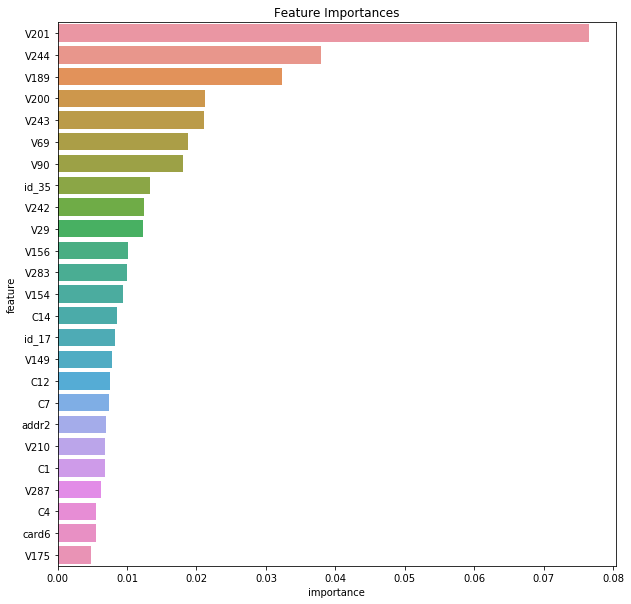

In [102]:
pred=build_model(xgb_params,model='xgb')

In [103]:
sub=pd.read_csv('../input/sample_submission.csv')
sub['isFraud']=pred
sub.to_csv('submission.csv',index=False)